2017 Edition

# Estimating Financial Risk through Monte Carlo Simulation
Risk analysis is part of every decision we make when faced with uncertainty, ambiguity, and variability. Indeed, even though we have unprecedented access to information, we can't accurately predict the future. In finance, there is a fair amount of uncertainty and risk involved with estimating the future value of financial products, due to the wide variety of potential outcomes. Monte Carlo simulation (also known as the Monte Carlo Method) allows inspecting many possible outcomes of the decision making process, and can be used to assess the impact of risk: this, in turns, allows for better decision-making under uncertainty.

## Goals
The main objectives we set for this Notebook are as follows:
1. Develop fundamental knowledge about Risk analysis
2. Understand Monte Carlo Simulation (MCS)
3. Apply Monte Carlo Simulation for predicting risk


## Steps
1. First, in section 1, we introduce the basics of MCS
2. In section 2, we work on a simple example to where we apply the MCS method
3. In section 3, we briefly summarize the main characteristics of the Monte Carlo Simulation (MCS) technique
4. In section 4, we overview the common distributions which are often used in MCS
5. In section 5, we work on a real use case, that focuses on estimating financial risk. We will use techniques such as featurization  (that is, generating additional features to improve model accuracy), linear regression, kernel density estimation, sampling distributions and so on ...

## Reference
This Notebook is inspired by Chapter 9 of the book [Advanced Analytics with Spark](http://shop.oreilly.com/product/0636920035091.do) by Josh Wills, Sandy Ryza, Sean Owen, and Uri Laserson. It is strongly suggested to read this Chapter to get a general idea of the topic of this Notebook.

# 1. Introduction

## 1.1. Monte Carlo Simulation (MCS)
Monte Carlo simulation is a computerized mathematical technique that can be applied such that it is possible to account for risk in quantitative analysis and decision making. This technique is used in many different fields, such as R&D, risk management, portfolio management, pricing derivatives, strategic planning, project planning, cost modeling and many more.

In general, MCS is a technique that "converts" uncertainty on input variables of a model into **probability distributions**. By combining the distributions and randomly selecting values from them, it recalculates the simulated model many times, to determine the probability of the output.

Historically, this technique was first used by scientists working on the atomic bomb: it was named after Monte Carlo, the Monaco resort town renowned for its casinos.  Since its introduction in World War II, Monte Carlo simulation has been used to model a variety of physical and conceptual systems.

## 1.2. How does it work?
Monte Carlo simulation performs risk analysis by building models of possible results by *substituting a range of possible input values, that constitute uncertainty, into a statistical distribution*. It then computes possible outcomes repeatedly, each time using a different set of random values from the probability functions that "model" the input. Depending upon the number of random input variables and their distribution, a Monte Carlo simulation could involve thousands or tens of thousands of "rounds" before it is complete. When complete, *Monte Carlo simulation produces distributions of possible outcome values*.

By using probability distributions instead of actual input samples, it is possible to model more accurately uncertainty: different choices of distributions will yield different outputs.

# 2. Illustrative example

Imagine you are the marketing manager for a firm that is planning to introduce a new product. You need to estimate the first-year net profit from this product, which might depend on:

- Sales volume in units
- Price per unit (also called "Selling price")
- Unit cost
- Fixed costs

Net profit will be calculated as $Net Profit = Sales Volume* (Selling Price - Unit cost) - Fixed costs$.  Fixed costs (accounting for various overheads, advertising budget, etc.) are known to be \$ 120,000, which we assume to be deterministic. All other factors, instead, involve some uncertainty: *sales volume* (in units) can cover quite a large range, the *selling price* per unit will depend on competitor actions, which are hard to predict, and *unit costs* will also vary depending on vendor prices and production experience, for example.

Now, to build a risk analysis model, we must first identify the uncertain variables -- which are essentially random variables.  While there's some uncertainty in almost all variables in a business model, we want to focus on variables where the range of values is significant.

## 2.1. Unit sales and unit price

Based on a hypothetical market research you have done, you have beliefs that there are equal chances for the market to be `slow`, `normal`, or `hot`:

- In a "slow" market, you expect to sell 50,000 units at an average selling price of \$11.00 per unit
- In a "normal" market, you expect to sell 75,000 units, but you'll likely realize a lower average selling price of \$10.00 per unit
- In a "hot" market, you expect to sell 100,000 units, but this will bring in competitors, who will drive down the average selling price to \$8.00 per unit

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

In [1]:
import os
import sys
import re
import builtins
import math
from pyspark import SparkContext
#from pyspark import SparkContext
#from pyspark.sql import SQLContext
#from pyspark.sql.types import *
#from pyspark.sql import Row
#from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns
import calendar
import datetime
from time import time
from sklearn import mixture

/opt/conda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


### Question 1
<div class="alert alert-info">
Calculate the average units and the unit price that you expect to sell, which depend on the market state. Use the assumptions above to compute the expected quantity of products and their expected unit price. 
</div>


```python
average_unit = ...
average_price = ...
print("average unit:", average_unit)
print("average_price:", average_price)
```

In [2]:
import numpy as np

units = np.array([100000,75000,50000])
prices = np.array([8.0,10.0,11.0])
average_unit = np.mean(units)
average_price = np.mean(prices)
print("average unit:", average_unit)
print("average_price:", average_price)


average unit: 75000.0
average_price: 9.66666666667


## 2.2. Unit Cost

Another uncertain variable is Unit Cost. In our illustrative example, we assume that your firm's production manager advises you that unit costs may be anywhere from \$5.50 to \$7.50, with a most likely expected cost of \$6.50. In this case, the most likely cost can be considered as the average cost.

## 2.3. A Flawed Model: using averages to represent our random variables
Our next step is to identify uncertain functions -- also called functions of a random variable.  Recall that Net Profit is calculated as $Net Profit = Sales Volume * (Selling Price - Unit cost) - Fixed costs$.  However, Sales Volume, Selling Price and Unit Cost are all uncertain variables, so Net Profit is an uncertain function.

The simplest model to predict the Net Profit is using average of sales volume, average of selling price and average of unit cost for calculating. So, if only consider averages, we can say that the $Net Profit = 75,000*(9.66666666 - 6.5) - 120,000 \sim 117,500$.

However, as [Dr. Sam Savage](http://web.stanford.edu/~savage/faculty/savage/) warns, "Plans based on average assumptions will be wrong on average." The calculated result is far from the actual value: indeed, the **true average Net Profit** is roughly  \$93,000, as we will see later in the example.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 2
#### Question 2.1
<div class="alert alert-info">
Write a function named `calNetProfit` to calculate the Net Profit using the average of sales volume, the average of selling price and the average of unit cost.
</div>

```python
def calNetProfit(average_unit, average_price, average_unitcost, fixed_cost):
    return ...

average_unitcost = ...
fixed_cost = ...
NetProfit = calNetProfit(...,...,...,...)
print("Net profit:", NetProfit)
```

In [3]:
def calNetProfit(sales_volume, price, unit_cost, fixed_cost):
    return sales_volume * (price-unit_cost)-fixed_cost

average_unitcost = 6.50
fixed_cost = 120000
NetProfit = calNetProfit(average_unit,average_price,average_unitcost,fixed_cost)
print("Net profit:", NetProfit)

Net profit: 117500.0


#### Question 2.2
<div class="alert alert-info">
Verify the warning message of Dr. Sam Savage by calculating the error of our estimated Net Profit using averages only. Recall that the true value is roughly \$93,000, so we are interested in:
<ul></ul>

$$ error = \frac{your\_value - true\_value}{true\_value}$$

<ul></ul>
Note also we are interested in displaying the error as a percentage.
<ul></ul>
Looking at the error we make, do you think that we can use the current model that only relies on averages?
</div>

```python
trueNetProfit = ...
error = (... - ...) / (...)
print("Error in percentage:", error * ...)
```

In [4]:
def computeError(NetProfit,trueNetProfit):
    error = (NetProfit - trueNetProfit) / (trueNetProfit)
    return builtins.abs(error)

In [5]:
trueNetProfit = 93000
error = computeError(NetProfit,trueNetProfit)
print("Error in percentage: %.2f%%" %(error * 100))

Error in percentage: 26.34%


<div class="alert alert-success">
A 26% error seems a quite big. In fact, reasoning about what we are doing, we are estimating an uncertain function based on 4 input arguments and 3 of them are uncertain variables (Sales Volume, Selling Price and Unit Cost),which where calculated as averages. So the final result depends on a too big approximation.
</div>

## 2.4. Using the Monte Carlo Simulation method to improve our model
As discussed before, the selling price and selling volume both depend on the state of the market scenario (slow/normal/hot). So, the net profit is the result of two random variables: `market scenario` (which in turn determines `sales volumes` and `selling price`) and `unit cost`.

Now, let's assume (this is an *a-priori* assumption we make) that `market scenario` follows a discrete, uniform distribution and that `unit cost` also follows a uniform distribution. Then, we can compute directly the values for selling price and selling volumes based on the outcome of the random variable `market scenario`, as shown in Section 2.1.

From these a-priori distributions, in each run (or trial) of our Monte Carlo simulation, we can generate the sample value for each random variable and use it to calculate the Net Profit. The more simulation runs, the more accurate our results will be. For example, if we run the simulation 100,000 times, the average net profit will amount to roughly \$92,600. Every time we run the simulation, a different prediction will be output: the average of such predictions will consistently be less than \$117,500, which we predicted using averages only.

Note also that in this simple example, we generate values for the `market scenario` and `unit cost` independently: we consider them to be **independent random variables**. This means that the eventual (and realistic!) correlation between the `market scenario` and `unit cost` variables is ignored. Later, we will learn how to be more precise and account for dependency between random variables.


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 3
#### Question 3.1
<div class="alert alert-info">
Write a function named `get_sales_volume_price` that returns the sales volume and price based on the market scenario. In particular, the scenario can get one of three values:
<ul>
  <li>0: Slow market</li>
  <li>1: Normal market</li>
  <li>2: Hot market</li>
</ul>  

The return value is a tuple in the form: `(sales_volume, price)`
</div>

```python
# Get sales volume and  price based on market scenario
# the function returns a tuple of (sales_volume, price)
def get_sales_volume_price(scenario):
    # Slow market
    if scenario == 0:
        return (...,...)
    # Normal market
    if ...
    # Hot market
    if ...
```

In [6]:
# Get sales volume and  price based on market scenario
# the function returns a tuple of (sales_volume, price)
def get_sales_volume_price(scenario):
    # Slow market
    if scenario == 0:
        return (50000,11)
    # Normal market
    if scenario == 1:
        return (75000,10)
    # Hot market
    if scenario == 2:
        return (100000,8)


#### Question 3.2
<div class="alert alert-info">
Run 100,000 Monte Carlo simulations and calculate the average net profit they produce. Then, compare the result to the "average model" we used in the previous questions (the one we called "flawed" model). Put your comments about the discrepancies between a simplistic model, and the more accurate MCS approach.  
<ul></ul>
Note that in each iteration, the `unit_cost` and `market_scenario` are generated according to their distributions. Also, recall what we have seen in Section 2.2: your firm account manager helped you with some research, to determine the variability of your random variables.  
</div>


<div class="label label-success">HINT</div>  

Function `uniform(a,b)` in module `random` generates a number $a<=c<=b$, which is drawn from a uniform distribution.  

Function `randint(a,b)` helps you generating an integer number $a<=c<=b$

```python
import random

total = 0.0
num_simulation = 100000
for i in range(0,num_simulation):
    unit_cost = ...
    market_scenario = ...
    sales_volume, price = get_sales_volume_price(...)
    netProfit = ...
    total = ...

print("average net profit:", ...)
```

In [7]:
import random

def runMonteCarlo(num_simulations): 
    fixed_cost = 120000
    all_results = np.array([])
    for i in range(0,num_simulations):
        unit_cost = np.random.uniform(5.5, 7.5)
        market_scenario = np.random.randint(0,3)
        sales_volume, price = get_sales_volume_price(market_scenario)
        netProfit = calNetProfit(sales_volume,price,unit_cost,fixed_cost)
        all_results = np.append(all_results, netProfit)
    return np.mean(all_results),all_results

In [8]:
avg_net_profit,all_results= runMonteCarlo(100000)

print("average net profit: %.2f" % avg_net_profit)

average net profit: 92465.58


In [9]:
error_1 = computeError(avg_net_profit,trueNetProfit)

print("Error in percentage: %.2f%%" %(error_1 * 100))

Error in percentage: 0.57%


In [10]:
trials = []
for i in range(10):
    avg_net_profit_,all_results = runMonteCarlo(100000)
    moving_mean = []
    moving_err = []
    for x in [10,25,50,100,200,400,800,1600,3200,6400,10000,20000,40000,100000]:
        moving_mean.append(np.mean(all_results[:x]))
    moving_err = list(map(lambda x: computeError(x,trueNetProfit), moving_mean))
    trials.append((moving_mean,moving_err,trueNetProfit))

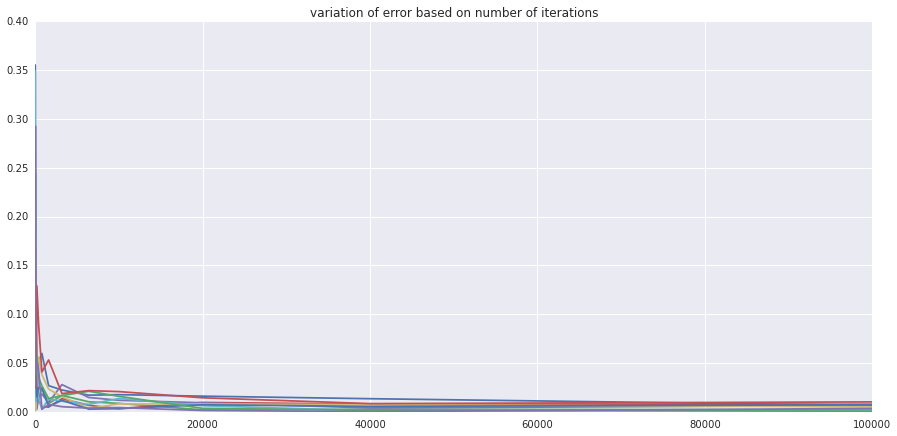

In [11]:
plt.figure(figsize = (15,7))
sns.set_style("darkgrid")
for trial in trials:    
    plt.plot([10,25,50,100,200,400,800,1600,3200,6400,10000,20000,40000,100000],trial[1] , '-')
    plt.title('variation of error based on number of iterations')

plt.show()

<div class="alert alert-success">
We note that the error decreases incredibly fast with the number of iterations, after 10000 we obtain a stable error, which is less than 0.01. 
We plotted different runs to appreciate the variability of the results. We see that all the trials follow the same pattern, but at the end, they stabilize at different values, this means that the starting position can actually change the final result, but at the end the final variation is really small.
</div>

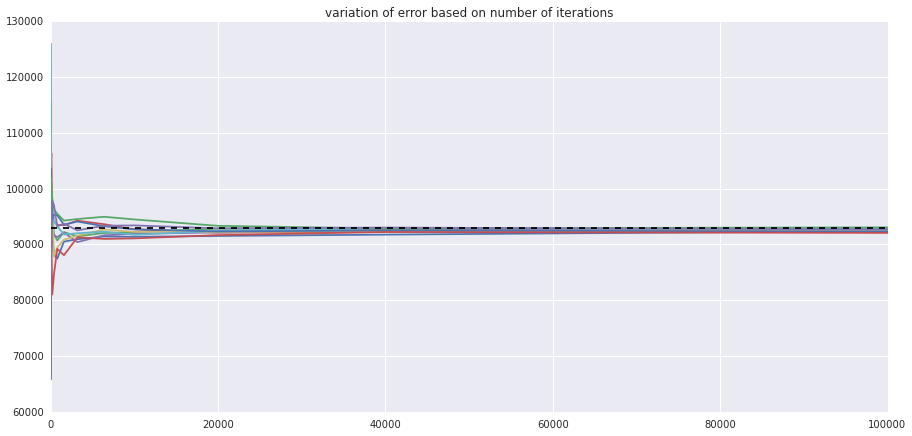

In [12]:
plt.figure(figsize = (15,7))
sns.set_style("darkgrid")
for trial in trials:    
    plt.plot([10,25,50,100,200,400,800,1600,3200,6400,10000,20000,40000,100000],trial[0] , '-')
    plt.title('variation of error based on number of iterations')
true_net = [trueNetProfit for x in trials[0][0]]
plt.plot([10,25,50,100,200,400,800,1600,3200,6400,10000,20000,40000,100000],true_net , '--', color='black')
plt.show()

<div class="alert alert-success">
Looking at the profit (black dashed line is the true net profit), we can confirm what we have seen before, the error is really low and all the trials converge at values near the target.
</div>


# 3. A brief summary of the Monte Carlo Simulation (MCS) technique

- A MCS allows several inputs to be used at the same time to compute the probability distribution of one or more outputs
- Different types of probability distributions can be assigned to the inputs of the model, depending on any *a-priori* information that is available. When the distribution is completely unknown, a common technique is to use a distribution computed by finding the best fit to the data you have
- The MCS method is also called a **stochastic method** because it uses random variables. Note also that the general assumption is for input random variables to be independent from each other. When this is not the case, there are techniques to account for correlation between random variables.
- A MCS generates the output as a range instead of a fixed value and shows how likely the output value is to occur in that range. In other words, the model outputs a probability distribution.

# 4. Common distributions used in MCS
In what follows, we summarize the most common probability distributions that are used as *a-priori* distributions for input random variables:

- *Normal/Gaussian Distribution*: this is a continuous distribution applied in situations where the mean and the standard deviation of a given input variable are given, and the mean represents the most probable value of the variable. In other words, values "near" the mean are most likely to occur.  This is symmetric distribution, and it is not bounded in its co-domain. It is very often used to  describe natural phenomena, such as people’s heights, inflation rates, energy prices, and so on and so forth. An illustration of a normal distribution is given below:
![normal_distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/320px-Normal_Distribution_PDF.svg.png)

- *Lognormal Distribution*: this is a distribution which is appropriate for variables taking values in the range $[0, \infty]$. Values are positively skewed, not symmetric like a normal distribution.  Examples of variables described by some lognormal distributions include, for example, real estate property values, stock prices, and oil reserves. An illustration of a lognormal distribution is given below:
![log_normal_distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/PDF-log_normal_distributions.svg/320px-PDF-log_normal_distributions.svg.png) 

- *Triangular Distribution*: this is a continuous distribution with fixed minimum and maximum values. It is bounded by the minimum and maximum values and can be either symmetrical (the most probable value = mean = median) or asymmetrical. Values around the most likely value (e.g. the mean) are more likely to occur.  Variables that could be described by a triangular distribution include, for example, past sales history per unit of time and inventory levels. An illustration of a triangular distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Triangular_distribution_PMF.png/320px-Triangular_distribution_PMF.png)

- *Uniform Distribution*: this is a continuous distribution bounded by known minimum and maximum values. In contrast to the triangular distribution, the likelihood of occurrence of the values between the minimum and maximum is the same. In other words, all values have an equal chance of occurring, and the distribution is simply characterized by the minimum and maximum values. Examples of variables that can be described by a uniform distribution include manufacturing costs or future sales revenues for a new product. An illustration of the uniform distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Uniform_Distribution_PDF_SVG.svg/320px-Uniform_Distribution_PDF_SVG.svg.png)

- *Exponential Distribution*: this is a continuous distribution used to model the time that pass between independent occurrences, provided that the rate of occurrences is known. An example of the exponential distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Exponential_pdf.svg/320px-Exponential_pdf.svg.png)

- *Discrete Distribution* : for this kind of distribution, the "user" defines specific values that may occur and the likelihood of each of them.  An example might be the results of a lawsuit: 20% chance of positive verdict, 30% change of negative verdict, 40% chance of settlement, and 10% chance of mistrial.


# 5. A real use case: estimating the financial risk of a portfolio of stocks
We hope that by now you have a good understanding about Monte Carlo simulation. Next, we apply this method to a real use case: *financial risk estimation*.

Imagine that you are an investor on the stock market. You plan to buy some stocks and you want to estimate the maximum loss you could incur after two weeks of investing. This is the quantity that the financial statistic "Value at Risk" (VaR) seeks to measure. [VaR](https://en.wikipedia.org/wiki/Value_at_risk) is defined as a measure of investment risk that can be used as a reasonable estimate of the maximum probable loss for a value of an investment portfolio, over a particular time period. A VaR statistic depends on three parameters: a portfolio, a time period, and a confidence level. A VaR of 1 million dollars with a 95% confidence level over two weeks, indicates the belief that the portfolio stands only a 5% chance of losing more than 1 million dollars over two weeks. VaR has seen widespread use across financial services organizations. This statistic plays a vital role in determining how much cash investors must hold to meet the credit ratings that they seek. In addition, it is also used to understand the risk characteristics of large portfolios: it is a good idea to compute the VaR before executing trades, such that it can help take informed decisions about investments. 

Our goal is calculating VaR of two weeks interval with 95% confidence level and the associated [VaR confidence interval](http://www.investopedia.com/ask/answers/041615/whats-difference-between-confidence-level-and-confidence-interval-value-risk-var.asp).


## 5.1. Terminology
In this use case, we will use some terms that might require a proper definition, given the domain. This is what we call the *Domain Knowledge*.

- **Instrument**: A tradable asset, such as a bond, loan, option, or stock investment. At any particular time, an instrument is considered to have a value, which is the price for which it can be sold. In the use case of this notebook, instruments are stock investments.
- **Portfolio**: A collection of instruments owned by a financial institution. 
- **Return**: The change in an instrument or portfolio’s value over a time period. 
- **Loss**: A negative return. 
- **Index**: An imaginary portfolio of instruments. For example, the NASDAQ Composite index includes about 3,000 stocks and similar instruments for major US and international companies. 
- **Market factor**: A value that can be used as an indicator of macro aspects of the financial climate at a particular time. For example, the value of an index, the Gross Domestic Product of the United States, or the exchange rate between the dollar and the euro. We will often refer to market factors as just factors.

## 5.2. The context of our use case
We have a list of instruments that we plan to invest in. The historical data of each instrument has been collected for you. For simplicity, assume that the returns of instruments at a given time, depend on 4 market factors only: 

- GSPC value
- IXIC value 
- The return of crude oil
- The return of treasury bonds

Our goal is building a model to predict the loss after two weeks' time interval with confidence level set to 95%.

As a side note, it is important to realize that the approach presented in this Notebook is a simplified version of what would happen in a real Financial firm. For example, the returns of instruments at a given time often depend on more than 4 market factors only! Moreover, the choice of what constitute an appropriate market factor is an art!



## 5.3. The Data
The stock data can be downloaded (or scraped) from Yahoo! by making a series of REST calls. The data includes multiple files. Each file contains the historical information of each instrument that we want to invest in. The data is in the following format (with some samples):
```
Date, Open, High, Low, Close, Volume, Adj Close
2016-01-22,66.239998,68.07,65.449997,67.860001,137400,67.860001
2016-01-21,65.410004,66.18,64.459999,65.050003,148000,65.050003
2016-01-20,64.279999,66.32,62.77,65.389999,141300,65.389999
2016-01-19,67.720001,67.989998,64.720001,65.379997,178400,65.379997
```

The data of GSPC and IXIC values (our two first market factors) are also available on Yahoo! and use the very same format. 

The crude oil and treasure bonds data is collected from investing.com, and has a different format, as shown below (with some samples):
```
Date    Price   Open    High    Low     Vol.    Change %
Jan 25, 2016    32.17   32.36   32.44   32.10   -       -0.59%
Jan 24, 2016    32.37   32.10   32.62   31.99   -       0.54%
Jan 22, 2016    32.19   29.84   32.35   29.53   -       9.01%
Jan 21, 2016    29.53   28.35   30.25   27.87   694.04K 11.22%
Jan 20, 2016    26.55   28.33   28.58   26.19   32.11K  -6.71%
Jan 19, 2016    28.46   29.20   30.21   28.21   188.03K -5.21%
```

In our use case, the factors' data will be used jointly to build a statistical model: as a consequence, we first need to preprocess the data to proceed.

## 5.4. Data preprocessing
In this Notebook, all data files have been downloaded for you, such that you can focus on pre-processing. Next, we will:

  - Read the factor data files which are in two different formats, process and merge them together
  - Read the stock data and pre-process it
  - Trim all data into a specific time region
  - Fill in the missing values
  - Generate the data of returns in each two weeks' time interval window
  
### Factor data pre-processing

We need two functions to read and parse data from Yahoo! and Investing.com respectively. We are interested only in information about the time and the corresponding returns of a factor or an instrument: as a consequence, we will project away many columns of our RAW data, and keep only the information we are interested in.

The 3000-instrument and the 4-factor history are small enough to be read and processed locally: we do not need to use the power of parallel computing to proceed. Note that this is true also for larger cases with hundreds of thousands of instruments and thousands of factors. The need for a distributed system like Spark comes in when actually **running** the Monte Carlo simulations, which can require massive amounts of computation on each instrument. 

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 4
#### Question 4.1
<div class="alert alert-info">
Write a function named `readInvestingDotComHistory` to parse data from investing.com based on the format specified above (see Section 5.3). Recall that we use two factors here: one that is related to the price of crude oil, one that is related to some specific US bonds. 

<ul></ul>

Print the first 5 entries of the first factor (crude oil price) in the parsed data.

<ul></ul>

Note that we are only interested in the date and price of stocks.

</div>

<div class="label label-success">HINT</div>  
You can parse a string to `datetime` object by using the function `strptime(<string>, <dtime_format>)`. In this case, the datetime format is `"%b %d, %Y"`. For more information, please follow this [link](https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior).

In the next cell, we simply copy data from our HDFS cluster (that contains everything we need for this Notebook) to the instance (a Docker container) running your Notebook. This means that you will have "local" data that you can process without using Spark. Note the folder location: find and verify that you have correctly downloaded the files!

In [13]:
! [ -d monte-carlo-risk ] || (echo "Downloading prepared data from HDFS. Please wait..." ; hdfs dfs -copyToLocal /datasets/monte-carlo-risk . ; echo "Done!";)

```python
from datetime import datetime
from datetime import timedelta
from itertools import islice
%matplotlib inline
import numpy as np
import statsmodels.api as sm

base_folder = "monte-carlo-risk/"

factors_folder= base_folder + "factors/"

# read data from local disk
def readInvestingDotComHistory(fname):
    def process_line(line):
        cols = line.split(...)
        date = datetime.strptime(..., ...)
        value = float(...)
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header....
        return list(map(process_line , content))

factor1_files = ['crudeoil.tsv', 'us30yeartreasurybonds.tsv']
factor1_files = map(lambda fn: factors_folder + fn, factor1_files)
factors1 = [readInvestingDotComHistory(f) for f in factor1_files]

print(factors1...)
```

In [14]:
from datetime import datetime
from datetime import timedelta
from itertools import islice
%matplotlib inline
import numpy as np
import statsmodels.api as sm

base_folder = "monte-carlo-risk/"

factors_folder= base_folder + "factors/"


# read data from local disk
def readInvestingDotComHistory(fname):
    def process_line(line):
        cols = line.split("\t")
        try:
            date = datetime.strptime(cols[0], "%b %d, %Y") # month, day, year
        except:
            date = datetime.strptime(cols[0], "%m.%d.%Y") # month, day, year
        value = cols[1].replace(',','')
        value = float(value)
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        content = content_w_header[:0:-1]
        return list(map(process_line , content))

factor1_files = ['crudeoil.tsv', 'us30yeartreasurybonds.tsv']
factor1_files = map(lambda fn: factors_folder + fn, factor1_files)
#print(*factor1_files)
factors1 = [readInvestingDotComHistory(f) for f in factor1_files]

print(factors1[0][:5])

[(datetime.datetime(2006, 1, 26, 0, 0), 66.26), (datetime.datetime(2006, 1, 27, 0, 0), 67.76), (datetime.datetime(2006, 1, 30, 0, 0), 68.35), (datetime.datetime(2006, 1, 31, 0, 0), 67.92), (datetime.datetime(2006, 2, 1, 0, 0), 66.56)]


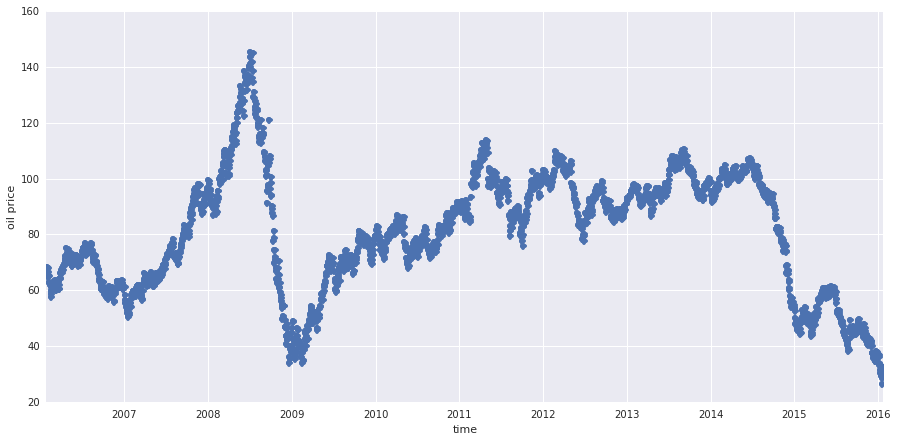

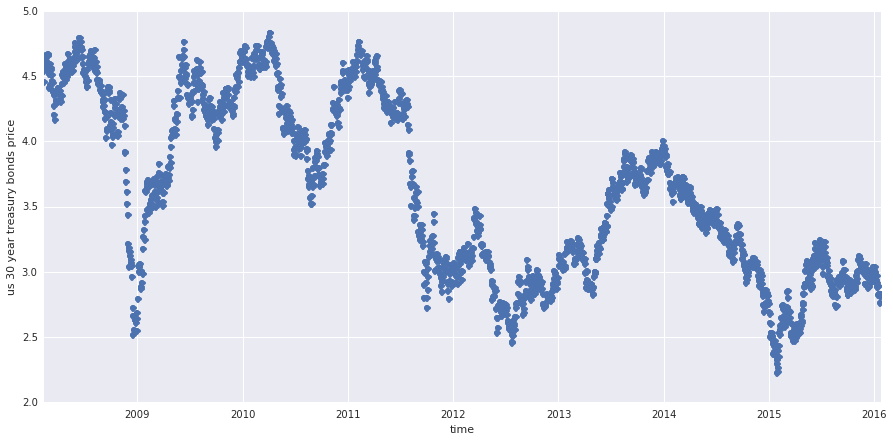

In [15]:
# todo: check middle line, put years
df = pd.DataFrame(factors1[0])
df.columns = ['date', 'price']
#print(df)
plt.figure(figsize = (15,7))
plt.xlabel("time")
plt.ylabel("oil price")
#sns.regplot(data = df.reset_index(), x = 'index', y = 'price')
plt.plot_date(df['date'] , df['price'])
#plt.xlim(0,len(df))
plt.show()

df = pd.DataFrame(factors1[1])
df.columns = ['date', 'price']
#print(df)
plt.figure(figsize = (15,7))
plt.xlabel("time")
plt.ylabel("us 30 year treasury bonds price")
#sns.regplot(data = df.reset_index(), x = 'index', y = 'price')
plt.plot_date(df['date'] , df['price'])
#plt.xlim(0,len(df))
plt.show()

<div class="alert alert-success">
Looking at the variation of the oil price and the treasury bonds price, we can easily see that they are quite different, but at the same time they share some peculiarities, expecially in 2009 and 2015, they both dropped. 
</div>


Now, the data structure `factors1` is a list, containing data that pertains to two (out of a total of four) factors that influence the market, as obtained by investing.com. Each element in the list is a tuple, containing some sort of timestamp, and the value of one of the two factors discussed above. From now on, we call these elements "**records**" or "**entries**". Visually, `factors1` looks like this:

| 0 (crude oil) | 1 (US bonds)|
| --- | --- |
| time_stamp, value | time_stamp, value |
| ... | ... |
| time_stamp, value | time_stamp, value |
| ... | ... |


#### Question 4.2
<div class="alert alert-info">
Write a function named `readYahooHistory` to parse data from yahoo.com based on its format, as described in Section 5.3.  
<ul></ul>
Print the first 5 entries of the first factor (namely GSPC). Comment the time range of the second batch of data we use in our Notebook.  
<ul></ul>

Note that we are only interested in the date and price of stocks.
</div>

<div class="label label-danger">NOTE</div> The datetime format now is in a different format than the previous one.

<div class="label label-success">HINT</div> Use a terminal (or put the bash commands inline in your Notebook) to list filenames in your local working directory to find and have a look at your local files.

```python
# read data from local disk
def readYahooHistory(fname):
    def process_line(line):
        ...
        ...
        ...
        ...
    
    with open(fname) as f:
        ...
        ...
        ...
        ...
    

factor2_files = [..., ...]
factor2_files = map(lambda fn: factors_folder + fn, factor2_files)

factors2 = [readYahooHistory(f) for f in factor2_files]

print(factors2[0][:5])
```

In [16]:
# read data from local disk
def readYahooHistory(fname):
    def process_line(line):
        cols = line.split(",")
        date = datetime.strptime(cols[0], "%Y-%m-%d") # year, month, day
        value = float(cols[1])
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        #print(content_w_header[0])
        #print(content_w_header[1])
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header[:0:-1]
        return list(map(process_line , content))
    

factor2_files = ['GSPC.csv','IXIC.csv']
factor2_files = map(lambda fn: factors_folder + fn, factor2_files)

factors2 = [readYahooHistory(f) for f in factor2_files]

print(factors2[0][:5])

[(datetime.datetime(1950, 1, 3, 0, 0), 16.66), (datetime.datetime(1950, 1, 4, 0, 0), 16.85), (datetime.datetime(1950, 1, 5, 0, 0), 16.93), (datetime.datetime(1950, 1, 6, 0, 0), 16.98), (datetime.datetime(1950, 1, 9, 0, 0), 17.08)]


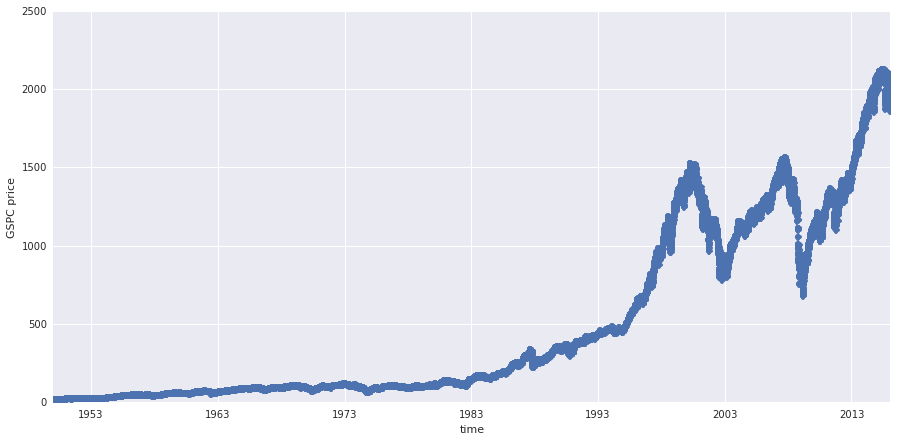

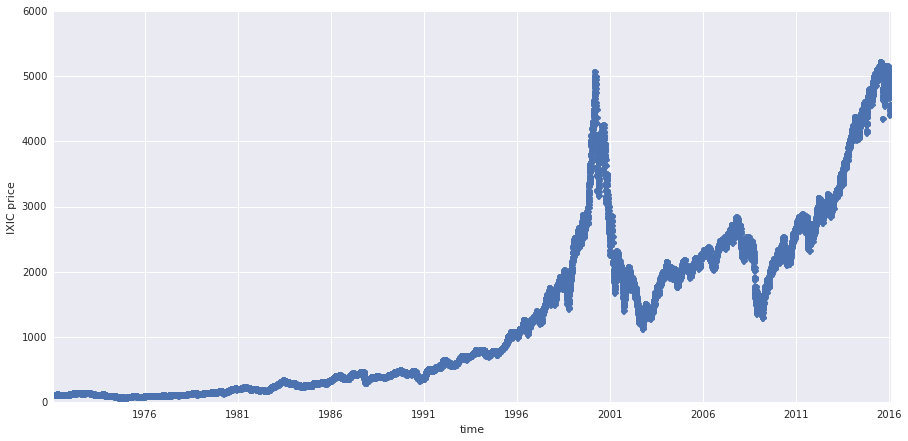

In [17]:
# todo: check middle line, put years, put label
df = pd.DataFrame(factors2[0])
df.columns = ['date', 'price']
#print(df)
plt.figure(figsize = (15,7))
plt.xlabel("time")
plt.ylabel("GSPC price")
plt.plot_date(df['date'] , df['price'])

plt.show()

df = pd.DataFrame(factors2[1])
df.columns = ['date', 'price']
plt.figure(figsize = (15,7))
plt.xlabel("time")
plt.ylabel("IXIC price")

plt.plot_date(df['date'] , df['price'])

plt.show()

<div class="alert alert-success">
Firstly we note that our stock datas are spread over a different time range.
<br>
Then we can appreciate a drop of the markets that happened in 2001, we looked for this https://en.wikipedia.org/wiki/Stock_market_downturn_of_2002

Anyway, we see again a recurrent pattern, peaks and drops happen at the same time, this means that our datas is highly correlated.
</div>

Now, the data structure `factors2` is again list, containing data that pertains to the next two (out of a total of four) factors that influence the market, as obtained by Yahoo!. Each element in the list is a tuple, containing some sort of timestamp, and the value of one of the two factors discussed above. Visually, `factors2` looks like this:

| 0 (GSPC) | 1 (IXIC)|
| --- | --- |
| time_stamp, value | time_stamp, value |
| ... | ... |
| time_stamp, value | time_stamp, value |
| ... | ... |


### Stock data pre-processing

Next, we prepare the data for the instruments we consider in this Notebook (i.e., the stocks we want to invest in). 

#### Question 4.3

<div class="alert alert-info">
In this Notebook, we assume that we want to invest on the first 35 stocks out of the total 3000 stocks present in our datasets.

<ul></ul>

Load and prepare all the data for the considered instruments (the first 35 stocks) which have historical information for more than 5 years. This means that all instruments with less than 5 years of history should be removed.

</div>

<div class="label label-success">HINT</div> we suggest to open a terminal window (not on your local machine, but the Notebook terminal that you can find on the Jupyter dashboard) and visually check the contents of the directories holding our dataset, if you didn't do this before! Have a look at how stock data is organized!

```python
from os import listdir
from os.path import isfile, join

stock_folder = base_folder + 'stocks'

def process_stock_file(fname):
    try:
        return ...
    except Exception as e:
        raise e
        return None



# select path of all stock data files in "stock_folder"
files = [join(stock_folder, f) for f in listdir(stock_folder) if isfile(join(stock_folder, f))]

# assume that we invest only the first 35 stocks (for faster computation)
files = files[:35]

# read each line in each file, convert it into the format: (date, value)
rawStocks = [... for f in files]

# select only instruments which have more than 5 years of history
# Note: the number of business days in a year is 260
number_of_years = 5
rawStocks = list(filter(lambda instrument: ...  , rawStocks))

# For testing, print the first 5 entry of the first stock
print(rawStocks[0][:5])

```

In [18]:
! (echo "Downloading prepared data from HDFS. Please wait..." ;head -n5 monte-carlo-risk/stocks/LKFN.csv)

Date,Open,High,Low,Close,Volume,Adj Close
2016-01-22,40.529999,40.75,40.189999,40.419998,109400,40.419998
2016-01-21,40.610001,40.93,39.799999,40.209999,69500,40.209999
2016-01-20,40.73,41.360001,40.529999,40.869999,150200,40.624999
2016-01-19,41.93,42.169998,41.240002,41.25,63800,41.002722


In [19]:
from os import listdir
from os.path import isfile, join

stock_folder = base_folder + 'stocks'

def process_stock_file(fname):
    try:
        return readYahooHistory(fname)
    except Exception as e:
        raise e
        return None



# select path of all stock data files in "stock_folder"
files = [join(stock_folder, f) for f in listdir(stock_folder) if isfile(join(stock_folder, f))]
#print(files)
# assume that we invest only the first 35 stocks (for faster computation)
files = files[:35]
# read each line in each file, convert it into the format: (date, value)
rawStocks = [process_stock_file(f) for f in files]

# select only instruments which have more than 5 years of history
# Note: the number of business days in a year is 260
number_of_years = 5
rawStocks = list(filter(lambda instrument : len(instrument)>= 260*number_of_years  , rawStocks))

# For testing, print the first 5 entry of the first stock
print(rawStocks[0][:5])

[(datetime.datetime(1997, 8, 14, 0, 0), 39.0), (datetime.datetime(1997, 8, 15, 0, 0), 42.0), (datetime.datetime(1997, 8, 18, 0, 0), 44.0), (datetime.datetime(1997, 8, 19, 0, 0), 55.5), (datetime.datetime(1997, 8, 20, 0, 0), 48.0)]


<div class="alert alert-success">
We used the yahoo reader because they have the same format used before
</div>


In [20]:
len(rawStocks)

29

<div class="alert alert-success">
We see that only 29 of 35 stocks selected meet our conditions.</div>


### Time alignment for our data
Different types of instruments may trade on different days, or the data may have missing values for other reasons, so it is important to make sure that our different histories align. First, we need to trim all of our time series to the same region in time. Then, we need to fill in missing values. To deal with time series that have missing values at the start and end dates in the time region, we simply fill in those dates with nearby values in the time region.

#### Question 4.4
<div class="alert alert-info">
Assume that we only focus on the data from 23/01/2009 to 23/01/2014. Write a function named `trimToRegion` to select only the records in that time interval. 

<ul></ul>

**Requirements**: after processing, each instrument $i$ has a list of records: $[r_0, r_2,...,r_{m_i}]$ such that $r_0$ and $r_{m_i}$ are assigned, respectively, the first and the last values corresponding to the extremes of the given time interval. For example: $r_0$ should contain the value at date 23/01/2009.
</div>

```python
# note that the data of crude oil and treasury is only available starting from 26/01/2006 
start = datetime(year=2009, month=1, day=23)
end = datetime(year=2014, month=1, day=23)

def trimToRegion(history, start, end):
    def isInTimeRegion(entry):
        (date, value) = entry
        return date >= ... and date <= ...

    # only select entries which are in the time region
    trimmed = list(filter( ..., ...))
    
    # if the data has incorrect time boundaries, add time boundaries
    if trimmed[0][0] != start:
        trimmed.insert(0, (..., trimmed[0][1]))
    if trimmed[-1][0] != end:
        trimmed.append((..., trimmed[-1][1]))
    return trimmed
    
# test our function
trimmedStock0  = trimToRegion(rawStocks[0], start, end)
# the first 5 records of stock 0
print(trimmedStock0[:5])
# the last 5 records of stock 0
print(trimmedStock0[-5:])

assert(trimmedStock0[0][0] == start), "the first record must contain the price in the first day of time interval"
assert(trimmedStock0[-1][0] == end), "the last record must contain the price in the last day of time interval"
```

In [21]:
# note that the data of crude oild and treasury is only available starting from 26/01/2006 
start = datetime(year=2009, month=1, day=23)
end = datetime(year=2014, month=1, day=23)


def trimToRegion(history, start, end):
    def isInTimeRegion(entry):
        (date, value) = entry
        return date >= start and date <= end

    # only select entries which are in the time region
    trimmed = list(filter(lambda record : isInTimeRegion(record), history))
    
    # if the data has incorrect time boundaries, add time boundaries
    if trimmed[0][0] != start:
        trimmed.insert(0, (start, trimmed[0][1]))
    if trimmed[-1][0] != end:
        trimmed.append((end, trimmed[-1][1]))
    return trimmed
    
# test our function
trimmedStock0  = trimToRegion(rawStocks[0], start, end)
# the first 5 records of stock 0
print(trimmedStock0[:5])
# the last 5 records of stock 0
print(trimmedStock0[-5:])

assert (trimmedStock0[0][0] == start), "the first record must contain the price in the first day of time interval"
assert (trimmedStock0[-1][0] == end), "the last record must contain the price in the last day of time interval"

[(datetime.datetime(2009, 1, 23, 0, 0), 19.4), (datetime.datetime(2009, 1, 26, 0, 0), 19.67), (datetime.datetime(2009, 1, 27, 0, 0), 19.809999), (datetime.datetime(2009, 1, 28, 0, 0), 20.469999), (datetime.datetime(2009, 1, 29, 0, 0), 21.41)]
[(datetime.datetime(2014, 1, 16, 0, 0), 37.369999), (datetime.datetime(2014, 1, 17, 0, 0), 37.470001), (datetime.datetime(2014, 1, 21, 0, 0), 37.73), (datetime.datetime(2014, 1, 22, 0, 0), 37.779999), (datetime.datetime(2014, 1, 23, 0, 0), 37.59)]


### Dealing with missing values
We expect that we have the price of instruments and factors **in each business day**. Unfortunately, there are many missing values in our data: this means that we miss data for some days, e.g. we have data for the Monday of a certain week, but not for the subsequent Tuesday. So, we need a function that helps filling these missing values.

Next, we provide to you the function to fill missing value: read it carefully!

In [22]:
def fillInHistory(history, start, end):
    curr = history
    filled = []
    idx = 0
    curDate = start
    numEntries = len(history)
    while curDate < end:
        
        # if the next entry is in the same day
        # or the next entry is at the weekend
        # but the curDate has already skipped it and moved to the next monday
        # (only in that case, curr[idx + 1][0] < curDate )
        # then move to the next entry
        while idx + 1 < numEntries and curr[idx + 1][0] <= curDate:
            idx +=1

        # only add the last value of instrument in a single day
        # check curDate is weekday or not
        # 0: Monday -> 5: Saturday, 6: Sunday
        if curDate.weekday() < 5:
            
            filled.append((curDate, curr[idx][1]))
            # move to the next business day
            curDate += timedelta(days=1)
        
        # skip the weekends
        if curDate.weekday() >= 5:
            # if curDate is Sat, skip 2 days, otherwise, skip 1 day
            curDate += timedelta(days=(7-curDate.weekday()))

    return filled

#### Question 4.5
<div class="alert alert-info">
Trim data of stocks and factors into the given time interval.
</div>

```python
#print rawStocks[0]

# trim into a specific time region
# and fill up the missing values
stocks = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(..., ..., ...), 
            start, end), 
        rawStocks))



# merge two factors, trim each factor into a time region
# and fill up the missing values
allfactors = factors1 + factors2
factors = list(map(
            ..., 
            allfactors
            ))
            
# test our code
print("the first 5 records of stock 0:", stocks[0][:5], "\n")
print("the last 5 records of stock 0:", stocks[0][-5:], "\n")
print("the first 5 records of factor 0:", factors[0][:5], "\n")
print("the first 5 records of factor 0:", factors[0][-5:], "\n")
```

In [23]:
#print rawStocks[0]

# trim into a specific time region
# and fill up the missing values
stocks = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
        rawStocks))

# merge two factors, trim each factor into a time region
# and fill up the missing values
allfactors = factors1 + factors2
factors = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
            allfactors
            ))
            
# test our code
print("the first 5 records of stock 0:", stocks[0][:5], "\n")
print("the last 5 records of stock 0:", stocks[0][-5:], "\n")
print("the first 5 records of factor 0:", factors[0][:5], "\n")
print("the first 5 records of factor 0:", factors[0][-5:], "\n")

the first 5 records of stock 0: [(datetime.datetime(2009, 1, 23, 0, 0), 19.4), (datetime.datetime(2009, 1, 26, 0, 0), 19.67), (datetime.datetime(2009, 1, 27, 0, 0), 19.809999), (datetime.datetime(2009, 1, 28, 0, 0), 20.469999), (datetime.datetime(2009, 1, 29, 0, 0), 21.41)] 

the last 5 records of stock 0: [(datetime.datetime(2014, 1, 16, 0, 0), 37.369999), (datetime.datetime(2014, 1, 17, 0, 0), 37.470001), (datetime.datetime(2014, 1, 20, 0, 0), 37.470001), (datetime.datetime(2014, 1, 21, 0, 0), 37.73), (datetime.datetime(2014, 1, 22, 0, 0), 37.779999)] 

the first 5 records of factor 0: [(datetime.datetime(2009, 1, 23, 0, 0), 46.47), (datetime.datetime(2009, 1, 26, 0, 0), 45.73), (datetime.datetime(2009, 1, 27, 0, 0), 41.58), (datetime.datetime(2009, 1, 28, 0, 0), 42.16), (datetime.datetime(2009, 1, 29, 0, 0), 41.44)] 

the first 5 records of factor 0: [(datetime.datetime(2014, 1, 16, 0, 0), 93.96), (datetime.datetime(2014, 1, 17, 0, 0), 94.37), (datetime.datetime(2014, 1, 20, 0, 0), 

## check how much data is missing

In [24]:
def percentageMissingValues(history, start, end):
    curr = [x[0] for x in history]
    full_days = sum(1 for x in curr if x.weekday() < 5 and x >= start and x < end)
    totalDays = np.busday_count(start.date(),end.date())
    numDaysMissing = totalDays - full_days
    
    return numDaysMissing * 100/totalDays

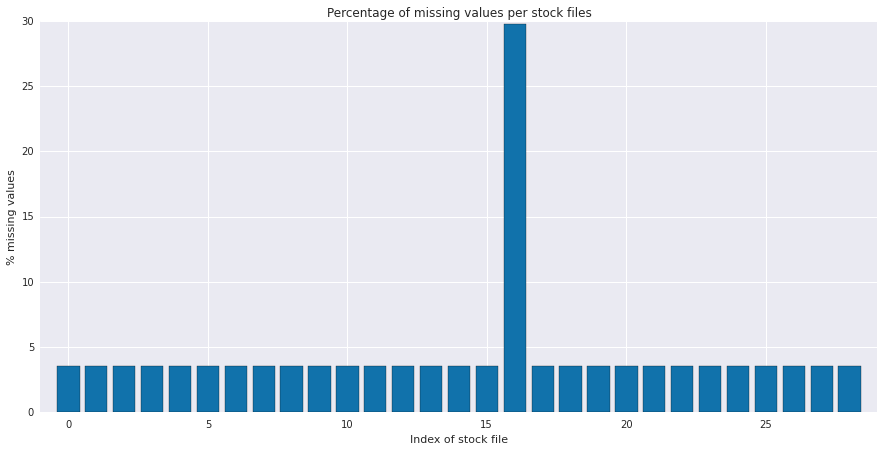

In [25]:
percentageMissingStocks = []
for rawStock in rawStocks:
    p = percentageMissingValues(rawStock,start,end)
    percentageMissingStocks.append(p)

plt.figure(figsize = (15,7))     
plt.bar(range(len(percentageMissingStocks)),percentageMissingStocks, align="center",color='#1172ab')
plt.xlabel("Index of stock file")
plt.ylabel("% missing values")
plt.xlim(-1, len(rawStocks))
plt.title("Percentage of missing values per stock files")
plt.show()

<div class="alert alert-success">
Most of the stocks have the same number of missing days, we have one exception. In any case, only 4% of missing days seems ok.
</div>

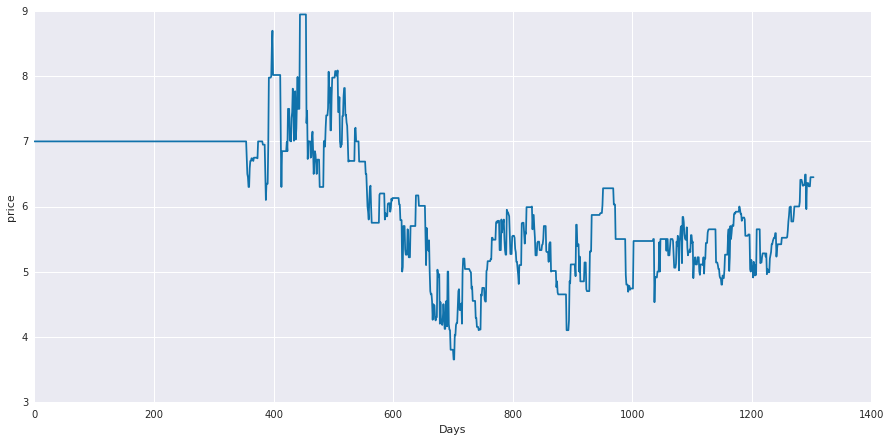

In [26]:
plt.figure(figsize = (15,7))     
plt.plot([x[1] for x in fillInHistory(trimToRegion(rawStocks[16],start,end),start,end)],color='#1172ab')
plt.xlabel("Days")
plt.ylabel("price")
plt.show()

<div class="alert alert-success">
We see that the outlier stock has a very strange pattern, in fact for the first 400 days it maintains the same price.
<br>
We saw that the roblem is in the preprocessing part, where we drop stocks that have a small history. The problem is that this stock passes the minimum number of day check because it goes from 2010 to 2016, but it does not have data before the 2015
</div>

<div class="alert alert-success">
In order to filter stocks with missing data in the target region, we decided to apply another filter that take in consideration the fact that the stocks has data that cover the target region, this means that stocks with a start date > target start date or end date < target end date will be dropped.
</div>

In [27]:
from os import listdir
from os.path import isfile, join

stock_folder = base_folder + 'stocks'

def process_stock_file(fname):
    try:
        return readYahooHistory(fname)
    except Exception as e:
        raise e
        return None



# select path of all stock data files in "stock_folder"
files = [join(stock_folder, f) for f in listdir(stock_folder) if isfile(join(stock_folder, f))]
#print(files)
# assume that we invest only the first 35 stocks (for faster computation)
files = files[:35]
# read each line in each file, convert it into the format: (date, value)
rawStocks = [process_stock_file(f) for f in files]

# select only instruments which have more than 5 years of history
# Note: the number of business days in a year is 260
number_of_years = 5
rawStocks = list(filter(lambda instrument : len(instrument)>= 260*number_of_years  , rawStocks))
rawStocks = list(filter(lambda instrument: instrument[0][0] <= start and instrument[-1][0] >= end , rawStocks))
rawStocks = list(filter(lambda instrument: np.max(list([x for x in zip(*instrument)])[1]) < 10000 , rawStocks))
    
# For testing, print the first 5 entry of the first stock
print(rawStocks[0][:5])

[(datetime.datetime(1997, 8, 14, 0, 0), 39.0), (datetime.datetime(1997, 8, 15, 0, 0), 42.0), (datetime.datetime(1997, 8, 18, 0, 0), 44.0), (datetime.datetime(1997, 8, 19, 0, 0), 55.5), (datetime.datetime(1997, 8, 20, 0, 0), 48.0)]


<div class="alert alert-success">
We decided to drop also stocks with strange values, e.g. values that are too much high, such as 10000 dollars
</div>

In [28]:
#print rawStocks[0]

# trim into a specific time region
# and fill up the missing values
rawStocks
stocks = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
        rawStocks))

# merge two factors, trim each factor into a time region
# and fill up the missing values
allfactors = factors1 + factors2
factors = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
            allfactors
            ))
            
# test our code
print("the first 5 records of stock 0:", stocks[0][:5], "\n")
print("the last 5 records of stock 0:", stocks[0][-5:], "\n")
print("the first 5 records of factor 0:", factors[0][:5], "\n")
print("the first 5 records of factor 0:", factors[0][-5:], "\n")

the first 5 records of stock 0: [(datetime.datetime(2009, 1, 23, 0, 0), 19.4), (datetime.datetime(2009, 1, 26, 0, 0), 19.67), (datetime.datetime(2009, 1, 27, 0, 0), 19.809999), (datetime.datetime(2009, 1, 28, 0, 0), 20.469999), (datetime.datetime(2009, 1, 29, 0, 0), 21.41)] 

the last 5 records of stock 0: [(datetime.datetime(2014, 1, 16, 0, 0), 37.369999), (datetime.datetime(2014, 1, 17, 0, 0), 37.470001), (datetime.datetime(2014, 1, 20, 0, 0), 37.470001), (datetime.datetime(2014, 1, 21, 0, 0), 37.73), (datetime.datetime(2014, 1, 22, 0, 0), 37.779999)] 

the first 5 records of factor 0: [(datetime.datetime(2009, 1, 23, 0, 0), 46.47), (datetime.datetime(2009, 1, 26, 0, 0), 45.73), (datetime.datetime(2009, 1, 27, 0, 0), 41.58), (datetime.datetime(2009, 1, 28, 0, 0), 42.16), (datetime.datetime(2009, 1, 29, 0, 0), 41.44)] 

the first 5 records of factor 0: [(datetime.datetime(2014, 1, 16, 0, 0), 93.96), (datetime.datetime(2014, 1, 17, 0, 0), 94.37), (datetime.datetime(2014, 1, 20, 0, 0), 

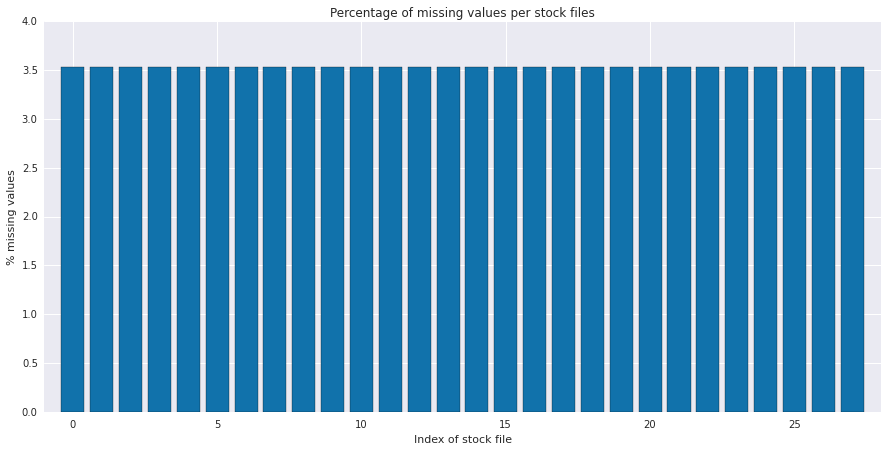

In [29]:
percentageMissingStocks = []
for rawStock in rawStocks:
    p = percentageMissingValues(rawStock,start,end)
    percentageMissingStocks.append(p)

plt.figure(figsize = (15,7))     
plt.bar(range(len(percentageMissingStocks)),percentageMissingStocks, align="center",color='#1172ab')
plt.xlabel("Index of stock file")
plt.ylabel("% missing values")
plt.xlim(-1, len(rawStocks))
plt.title("Percentage of missing values per stock files")
plt.show()

<div class="alert alert-success">
After the additional filter we obtain only stocks that have values that cover the target window
</div>

Recall that Value at Risk (VaR) deals with **losses over a particular time horizon**. We are not concerned with the absolute prices of instruments, but how those prices **change over** a given period of time. In our project, we will set that length to two weeks: we use the sliding window method to transform time series of prices into an overlapping sequence of price change over two-week intervals.

The figure below illustrates this process. The returns of market factors after each two-week interval is calculated in the very same way.

![](https://dl.dropboxusercontent.com/s/r9ucsicichb6gjh/two-week-time-interval.svg)

In [30]:
def buildWindow(seq, k=2):
    "Returns a sliding window (of width k) over data from iterable data structures"
    "   s -> (s0,s1,...s[k-1]), (s1,s2,...,sk), ...                   "
    it = iter(seq)
    result = tuple(islice(it, k))
    if len(result) == k:
        yield result  
    for elem in it:
        result = result[1:] + (elem,)
        yield result

#### Question 4.6
<div class="alert alert-info">
Compute the returns of the stocks after each two-week time window.
</div>

```python
def calculateReturn(window):
    # return the change of value after two weeks
    return ... - ...

def twoWeekReturns(history):
    # we use 10 instead of 14 to define the window
    # because financial data does not include weekends
    return [... for entry in buildWindow(..., 10)]

stocksReturns = list(map(twoWeekReturns, stocks))
factorsReturns = list(map(twoWeekReturns, factors))

# test our functions
print("the first 5 returns of stock 0:", stocksReturns[0][:5])
print("the last 5 returns of stock 0:", stocksReturns[0][-5:])
```

In [31]:
def calculateReturn(window):
    # return the change of value after two weeks
    return window[-1][1] - window[0][1]

def twoWeekReturns(history):
    # we use 10 instead of 14 to define the window
    # because financial data does not include weekends
    return [calculateReturn(entry) for entry in buildWindow(history, 10)]

stocksReturns = list(map(twoWeekReturns, stocks))
factorsReturns = list(map(twoWeekReturns, factors))

# test our functions
print("the first 5 returns of stock 0:", stocksReturns[0][:5])
print("the last 5 returns of stock 0:", stocksReturns[0][-5:])

the first 5 returns of stock 0: [0.8000010000000017, 1.0, 0.7200019999999974, -0.27999800000000263, -1.5800000000000018]
the last 5 returns of stock 0: [-1.1599999999999966, -1.4599989999999963, -0.8399999999999963, -0.4599990000000034, 0.0]


Alright! Now we have data that is properly aligned to start the training process: stocks' returns and factors' returns, per time windows of two weeks. Next, we will apply the MCS method.

## 5.5. Summary guidelines to apply the MCS method on the data we prepared
Next, we overview the steps that you have to follow to build a model of your data, and then use Monte Carlo simulations to produce output distributions:

- **Step 1**: Defining the relationship between the market factors and the instrument's returns. This relationship takes the form of a model fitted to historical data.
- **Step 2**: Defining the distributions for the market conditions (particularly, the returns of factors) that are straightforward to sample from. These distributions are fitted to historical data. 
- **Step 3**: Generate the data for each trial of a Monte Carlo run: this amount to generating the random values for market conditions along with these distributions.
- **Step 4**: For each trial, from the above values of market conditions, and using the relationship built in step 1, we calculate the return for each instrument and the total return. We use the returns to define an empirical distribution over losses. This means that, if we run 100 trials and want to estimate the 5% VaR, we would choose it as the loss from the trial with the fifth greatest loss.
- **Step 5**: Evaluating the result

## 5.6. Applying MCS

### Step 1: Defining relationship between market factors and instrument's returns

In our simulation, we will use a simple linear model. By our definition of return, a factor return is a **change** in the value of a market factor **over a particular time period**, e.g. if the value of the S&P 500 moves from 2000 to 2100 over a time interval, its return would be 100.

A vector that contains the return of 4 market factors is called a *market factor vector*. Generally, instead of using this vector as features, we derive a set of features from simple transformation of it. In particular, a vector of 4 values is transformed into a vector of length $m$ by function $F$. In the simplest case $F(v) = v$.

Denote $v_t$ the market factor vector, and $f_t$ the transformed features of $v_t$ at time $t$.

$f_{tj}$ is the value of feature $j$ in $f_t$.

Denote $r_{it}$ the return of instrument $i$ at time $t$ and $c_i$ the [intercept term](http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-to-interpret-the-constant-y-intercept) of instrument $i$.

We will use a simple linear function to calculate $r_{it}$ from $f_t$:

$$
r_{it} = c_i + \sum_{j=1}^{m}{w_{ij}*f_{tj}}
$$

where $w_{ij}$ is the weight of feature $j$ for instrument $i$.

All that above means that given a market factor vector, we have to apply featurization and then use the result as a surrogate for calculating the return of the instruments, using the above linear function.

There are two questions that we should consider: **how we apply featurization to a factor vector?** and **how to pick values for $w_{ij}$?**

**How we apply featurization to a factor vector?**
In fact, the instruments' returns may be non-linear functions of the factor returns. So, we should not use factor returns as features in the above linear function. Instead, we transform them into a set of features with different size. In this Notebook, we can include some additional features in our model that we derive from non-linear transformations of the factor returns. We will try adding two more features for each factor return: its square and its square root values. So, we can still assume that our model is a linear model in the sense that the response variable is a linear function of the new features. *Note that the particular feature transformation described here is meant to be an illustrative example of some of the options that are available: it shouldn't be considered as the state of the art in predictive financial modeling!!*.

**How to pick values for $w_{ij}$?**

For all the market factor vectors in our historical data, we transform them to feature vectors. Now, we have feature vectors in many two-week intervals and the corresponding instrument's returns in these intervals. We can use Ordinary Least Square (OLS) regression model to estimate the weights for each instrument such that our linear function can fit to the data. The parameters for OLS function are:

- `x`: The collection of columns where **each column** is the value of **a feature** in many two-week interval
- `y`: The return of an instrument in the corresponding time interval of x.

The figure below shows the basic idea of the process to build a statistical model for predicting the returns of stock X.

![](https://dl.dropboxusercontent.com/s/kbjtwmnr4w31uev/process-build-model3.svg)


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 5
#### Question 5.1

<div class="alert alert-info">
Currently, our data is in form of:  

$$
factorsReturns=
\begin{bmatrix}
 r_{00} & r_{01} & r_{02} & ... & r_{0k} \\
 r_{10} & r_{11} & r_{12} & ... & r_{1k} \\
 ... & ... & ... & ... & ... \\
 r_{n0} & r_{n1} & r_{n2} & ... & r_{nk}\\
\end{bmatrix}
$$

<ul></ul>

$$
stocksReturns=
\begin{bmatrix}
 s_{00} & s_{01} & s_{02} & ... & s_{0k} \\
 s_{10} & s_{11} & s_{12} & ... & s_{1k} \\
 ... & ... & ... & ... & ... \\
 s_{n0} & s_{n1} & s_{n2} & ... & s_{nk}\\
\end{bmatrix}
$$

<ul></ul>

Where, $r_{ij}$ is the return of factor $i^{th}$ in time window $j^{th}$, $k$ is the number of time windows, and $n$ is the number of factors. A similar definition goes for $s_{ij}$.

<ul></ul>

In order to use OLS, the parameter must be in form of:

<ul></ul>

$$
x=factorsReturns^T =
\begin{bmatrix}
 r_{00} & r_{10} & ... & r_{n0} \\
 r_{01} & r_{11} & ... & r_{n1} \\
 r_{02} & r_{12} & ... & r_{n2}\\
 ... & ... & ... & ... \\
 r_{0k} & r_{1k} & ... & r_{nk}\\
\end{bmatrix}
$$

<ul></ul>

Whereas, $y$ can be any row in `stocksReturns`.

<ul></ul>

So, we need a function to transpose a matrix. Write a function named `transpose` to do just that.
</div>

```python
def transpose(matrix):
    ...
    return ...
    
# test function
assert (transpose([[1,2,3], [4,5,6], [7,8,9]]) == [[1, 4, 7], [2, 5, 8], [3, 6, 9]]), "Function transpose runs incorrectly"
```

In [32]:
def transpose(matrix):
    return [list(i) for i in zip(*matrix)]
    
# test function
assert (transpose([[1,2,3], [4,5,6], [7,8,9]]) == [[1, 4, 7], [2, 5, 8], [3, 6, 9]]), "Function transpose runs incorrectly"

#### Question 5.2
<div class="alert alert-info">
Write a function named `featurize` that takes a list factor's returns $[x_1, x_2,...,x_k]$ and transform it into a new list of features $[u_1,u_2,..,u_k, v_1, v_2,..,v_k, x_1,x_2,...,x_k]$.

<ul></ul>

Where,  


$u_i$ = $\left\{
	\begin{array}{ll}
		x_i^2 & \mbox{if } x_i \geq 0 \\
		-x_i^2 & \mbox{if } x_i < 0
	\end{array}
\right.
$

<ul></ul>

and  

$v_i$ = $\left\{
	\begin{array}{ll}
		\sqrt{x_i} & \mbox{if } x_i \geq 0 \\
		-\sqrt{x_i} & \mbox{if } x_i < 0
	\end{array}
\right.
$  

</div>

```python
def featurize(factorReturns):
    squaredReturns = [...]
    squareRootedReturns = [...]
    # concat new features
    return ... + ... + ...

# test our function
assert (featurize([4, -9, 25]) == [16, -81, 625, 2, -3, 5, 4, -9, 25]), "Function runs incorrectly"
```

In [33]:

def sign(number):
    return -1 if number < 0 else 1


def featurize(factorReturns):
    factorReturns = list(factorReturns)
    squaredReturns = [sign(element)*(element)**2 for element in factorReturns]
    squareRootedReturns = [sign(element)*abs(element)**0.5 for element in factorReturns]
    # concat new features
    return squaredReturns + squareRootedReturns + factorReturns



# test our function
assert (featurize([4, -9, 25]) == [16, -81, 625, 2, -3, 5, 4, -9, 25]), "Function runs incorrectly"

#### Question 5.3
<div class="alert alert-info">
Using OLS, estimate the weights for each feature on each stock. What is the shape of `weights` (size of each dimension)?  

Explain it.
</div>

```python
def estimateParams(y, x):
    return sm.OLS(y, x).fit().params

# transpose factorsReturns
factorMat = ...

# featurize each row of factorMat
factorFeatures = list(map(...,...))

# OLS require parameter is a numpy array
factor_columns = np.array(factorFeatures)

#add a constant - the intercept term for each instrument i.
factor_columns = sm.add_constant(factor_columns, prepend=True)

# estimate weights
weights = [... for stockReturns in stocksReturns]

print("weights:", weights)

```

In [34]:
def estimateParams(y, x):
    return sm.OLS(y, x).fit().params

# transpose factorsReturns
factorMat = transpose(factorsReturns) 

# featurize each row of factorMat
factorFeatures = list(map(featurize,factorMat))

# OLS require parameter to be a numpy array
factor_columns = np.array(factorFeatures)

# add a constant - the intercept term for each instrument i.
factor_columns = sm.add_constant(factor_columns, prepend=True) 

# estimate weights
weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns] 
print("weights:", weights)

weights: [array([  8.94373632e-03,  -4.45428165e-04,  -3.86563671e+00,
         1.06990867e-05,  -1.77694077e-05,   4.18681717e-02,
        -5.45768303e-01,  -3.46329649e-02,  -4.83298453e-02,
        -1.60734343e-02,   2.46420475e+00,   1.39170002e-02,
         9.79575567e-03]), array([ -1.01169803e-01,   7.64097102e-03,   4.68000375e-01,
         1.49375666e-04,  -4.07127462e-05,   3.57737153e-01,
         7.78949230e-01,   6.33234151e-02,  -3.36420149e-02,
        -2.10131090e-01,  -7.29688300e-01,  -1.32331203e-02,
         2.44533396e-02]), array([ -1.41689702e-02,   2.50753524e-03,  -6.78126967e-01,
         3.13811357e-05,  -6.88239814e-06,   4.75787471e-02,
        -1.53916613e-02,   9.62293232e-03,  -2.17752591e-03,
        -5.13806214e-02,   2.38024901e-01,  -1.62644947e-03,
         1.77528973e-03]), array([  4.68456135e-02,  -1.16803302e-03,   5.34673980e+00,
         2.50910751e-05,  -1.48972151e-05,  -1.10127300e-02,
         1.84573244e+00,   4.91143595e-02,  -6.23965595

In [35]:
print("number of stocks: %d" % len(weights))
print("number of weights per stock: %d" % len(weights[0]))

number of stocks: 28
number of weights per stock: 13


<div class="alert alert-success">
Considering a single stock, we have 13 weights because we have 4 factors and we calcualte three weights per factor plus one that is the offset.
Since we have 28 stocks, and we calculate the weights for every stock, at the end we have 28 * 13 weights.
</div>


### Step 2: Defining the distributions for the market conditions
Since we cannot define the distributions for the market factors directly, we can only approximate their distribution.
The best way to do that, is plotting their value. However, these values may fluctuate quite a lot. 

Next, we show how to use the Kernel density estimation (KDE) technique to approximate such distributions. In brief, kernel density estimation is a way of smoothing out a histogram: this is achieved by assigning (or centering) a probability distribution (usually a normal distribution) to each data point, and then summing. So, a set of two-week-return samples would result in a large number of "super-imposed" normal distributions, each with a different mean. 

To estimate the probability density at a given point, KDE evaluates the PDFs of all the normal distributions at that point and takes their average. The smoothness of a kernel density plot depends on its *bandwidth*, and the standard deviation of each of the normal distributions. For a brief introduction on KDE, please refer to this [link](https://en.wikipedia.org/wiki/Kernel_density_estimation).

In [36]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kde import KDEUnivariate
import matplotlib.pyplot as plt
import scipy

def plotDistribution(samples, show=True):
    #print(samples)
    vmin = np.min(samples)
    vmax = np.max(samples)
    stddev = np.std(samples)
    
    domain = np.arange(vmin, vmax, (vmax-vmin)/100)
    
    # a simple heuristic to select bandwidth
    bandwidth = 1.06 * stddev * math.pow(len(samples), -.2)
    
    # estimate density
    kde = KDEUnivariate(samples)
    kde.fit(bw=bandwidth)
    density = kde.evaluate(domain)
    
    # plot
    if show:
        plt.plot(domain, density)
        plt.show()
    else:
        return domain,density

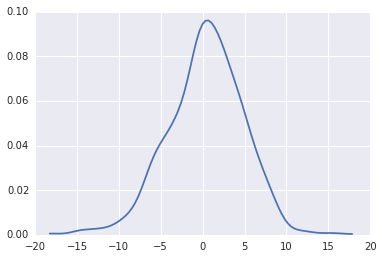

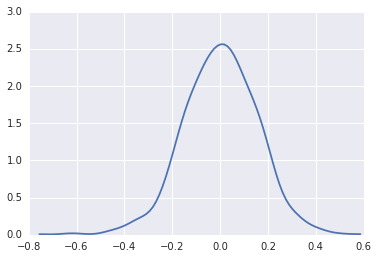

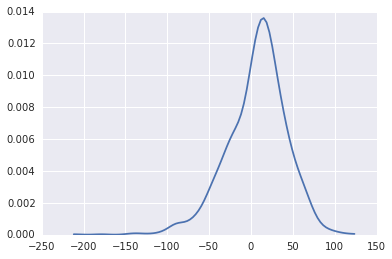

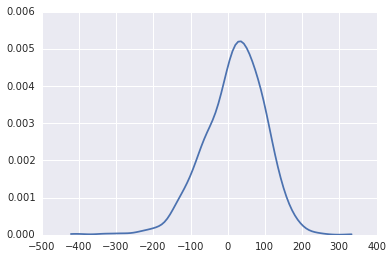

In [37]:
plotDistribution(factorsReturns[0])
plotDistribution(factorsReturns[1])
plotDistribution(factorsReturns[2])
plotDistribution(factorsReturns[3])

For the sake of simplicity, we can say that our smoothed versions of the returns of each factor can be represented quite well by a normal distribution. Of course, more exotic distributions, perhaps with fatter tails, could fit more closely the data, but it is outside the scope of this Notebook to proceed in this way.

Now, the simplest way to sample factors returns is to use a normal distribution for each of the factors, and sample from these distributions independently. However, this approach ignores the fact that market factors are often correlated. For example, when the price of crude oil is down, the price of treasury bonds is down too. We can check our data to verify about the correlation.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 6

#### Question 6.1
<div class="alert alert-info">

Calculate the correlation between market factors and explain the result.

</div>

<div class="label label-success">HINT</div> function `np.corrcoef` might be useful.

```python
correlation = ...
correlation
```

In [38]:
correlation = np.corrcoef(factorsReturns)
correlation

array([[ 1.        ,  0.38507954,  0.414966  ,  0.44278612],
       [ 0.38507954,  1.        ,  0.46210122,  0.49911941],
       [ 0.414966  ,  0.46210122,  1.        ,  0.92053356],
       [ 0.44278612,  0.49911941,  0.92053356,  1.        ]])

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


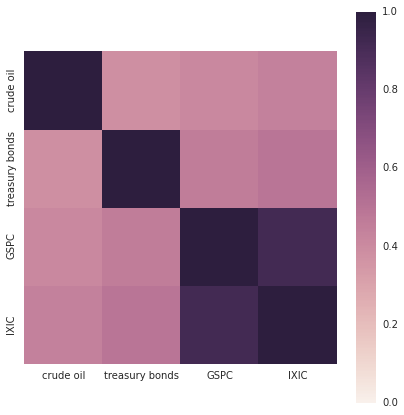

In [39]:
factor_names = ["crude oil", "treasury bonds", "GSPC", "IXIC"] 
f = plt.subplots(figsize=(7, 7))
ax = sns.heatmap(correlation, vmin=0, vmax=1, square=True)
ax.set(xticklabels=factor_names,yticklabels=factor_names[::-1])
print ()


<div class="alert alert-success">
We see that the 3rd and the 4th factor are highly correlated. 

These factors are GSPC and IXIC. 
<br>
Looking at the crude oil and the treasury bonds, we see that they are not correlated as we thought.
</div>


In [40]:
def plotVariation(factor_names):
    dimension  = len(factor_names)
    if dimension % 2==0:
        num_rows = int(dimension/2)
    else:
        num_rows = int(dimension/2) + 1
    f, axarr = plt.subplots(num_rows, 2)
    f.set_figwidth(15)
    f.set_figheight(len(factor_names)*2)
    for (idx,factorReturns) in enumerate(factorsReturns):
        i, j = divmod(idx, 2)
        ax = axarr[i, j]
        ax.plot(factorReturns)
        ax.set_title(factor_names[idx])
        ax.set_xlabel("2 weeks window") 
        ax.set_ylabel("variation of price over window") 
    f.subplots_adjust(hspace=0.3)

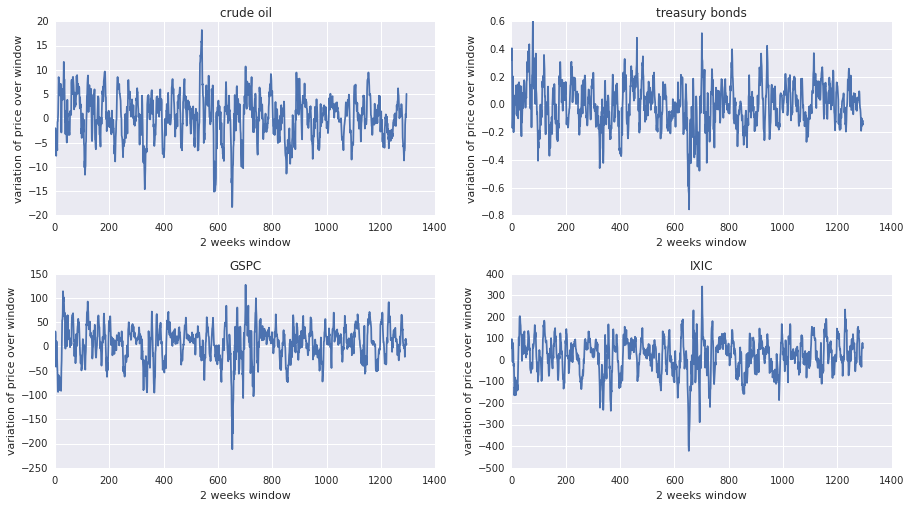

In [41]:
factor_names = ["crude oil", "treasury bonds", "GSPC", "IXIC"] 
plotVariation(factor_names)

<div class="alert alert-success">
As expected, GSPC and IXIC are highly correlated, in fact they basically have the same variation.
Instead, crude oil and treasury bonds are quite different, even though they share some peaks and drops.
<br>
We need to take attention at the treasury bond because we do not have the price of the last 200 days and we obtain a variation of price equal to zero.
</div>


The multivariate normal distribution can help here by taking the correlation information between the factors into account. Each sample from a multivariate normal distribution can be thought of as a vector. Given values for all of the dimensions but one, the distribution of values along that dimension is normal. But, in their joint distribution, the variables are not independent.

For this use case, we can write:

$$
\left(\begin{array}{c}f_{1}\\f_{2}\\f_{3}\\f_{4} \end{array}\right)
\sim N 
\left[
  \left(
    \begin{array}{c}
      \mu_1\\ \mu_2 \\ \mu_3 \\ \mu_4 
    \end{array}
  \right), 
  \left(
    \begin{array}{cccc}
      \sigma^2_1 & \rho_{12} \sigma_1\sigma_2 & \rho_{13} \sigma_1\sigma_3 & \rho_{14} \sigma_1\sigma_4 \\ 
      \rho_{12}\sigma_2\sigma_1 & \sigma^2_2 & \rho_{23} \sigma_2\sigma_3 & \rho_{24} \sigma_2\sigma_4\\
      \rho_{13} \sigma_3\sigma_1 & \rho_{23} \sigma_3\sigma_2 & \sigma^2_3 & \rho_{34} \sigma_3\sigma_4 \\ 
      \rho_{14} \sigma_4\sigma_1 & \rho_{24} \sigma_4\sigma_2 & \rho_{34} \sigma_3\sigma_4 & \sigma_4^2 \\ 
    \end{array}
  \right)
\right]
$$

Or,

$$
f_t \sim N(\mu, \sum)
$$

Where $f_1$, $f_2$, $f_3$ and $f_4$ are the market factors, $\sigma_i$ is the standard deviation of factor $i$, $\mu$ is a vector of the empirical means of the returns of the factors and $\sum$ is the empirical covariance matrix of the returns of the factors.

The multivariate normal is parameterized with a mean along each dimension and a matrix describing the covariance between each pair of dimensions. When the covariance matrix is diagonal, the multivariate normal reduces to sampling along each dimension independently, but placing non-zero values in the off-diagonals helps capture the relationships between variables. Whenever having the mean of this multivariate normal distribution and its covariance matrix, we can generate the sample values for market factors.

Next, we will calculate the mean and the covariance matrix of this multivariate normal distribution from the historical data.


#### Question 6.2
<div class="alert alert-info">

Calculate the covariance matrix $\sum$ and the means $\mu$ of factors' returns then generate a random vector of factors return that follows a multivariate normal distribution $\sim N(\mu, \sum)$

</div>

<div class="label label-success">HINT</div>
Function `np.cov` can help calculating covariance matrix. Function `np.random.multivariate_normal(<mean>, <cov>)` is often used for generating samples.

```python
factorCov = ...
factorMeans = [sum(...)/len(...) for ... in ...]
sample = ...
print(factorCov)
print(factorMeans)
print(sample)
```

In [42]:
factorCov = np.cov(factorsReturns)
factorMeans = [np.sum(factorReturns)/len(factorReturns) for factorReturns in factorsReturns]
sample = np.random.multivariate_normal(factorMeans, factorCov)
print(factorCov)
print(factorMeans)
print(sample)

[[  2.03712313e+01   2.70383097e-01   6.74442782e+01   1.63697774e+02]
 [  2.70383097e-01   2.42014227e-02   2.58869879e+00   6.36011613e+00]
 [  6.74442782e+01   2.58869879e+00   1.29672509e+03   2.71521187e+03]
 [  1.63697774e+02   6.36011613e+00   2.71521187e+03   6.70934736e+03]]
[0.35908880308880309, 0.0019722007722007724, 6.9703397891891896, 18.737721799999996]
[ -0.22300259   0.30127265  33.40192461  59.65317277]


<div class="alert alert-success">
Now we plot the normal estimate and the true distribution of each different factor to see if we fit them well.
</div>


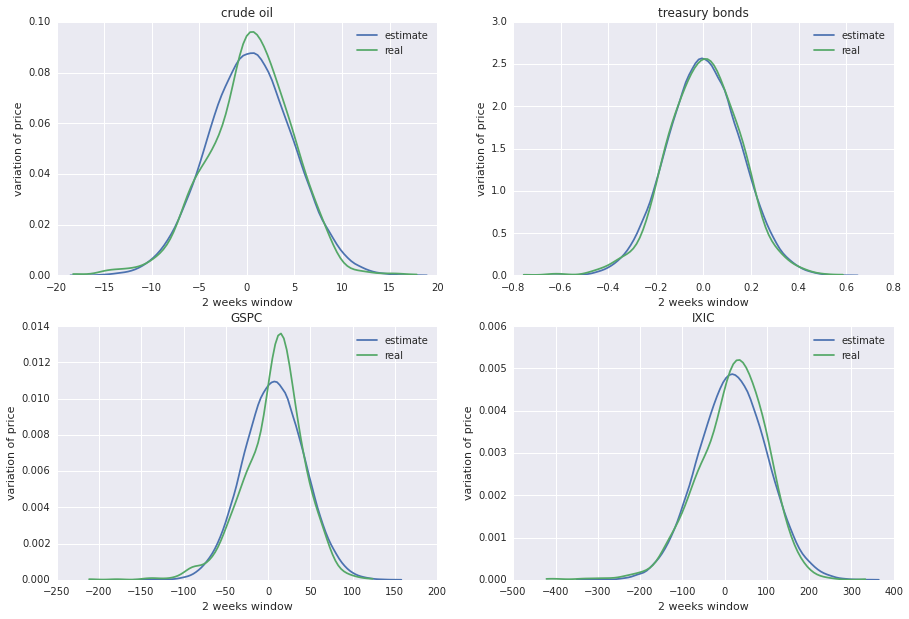

In [43]:
factorsNames = ["crude oil", "treasury bonds", "GSPC", "IXIC"] 
    
f, axarr = plt.subplots(2, 2)
f.set_figwidth(15)
f.set_figheight(10)
for (idx, factorReturn) in enumerate(factorsReturns):
    i, j = divmod(idx, 2)
    ax = axarr[i, j]
    normalEstimates = [x for x in zip(*np.random.multivariate_normal(factorMeans, factorCov,size=100000))][idx]
    domainEstimates, densityEstimates = plotDistribution(normalEstimates, show=False)
    domainFactor, densityFactor = plotDistribution(factorReturn, show=False)
    ax.plot(domainEstimates, densityEstimates)
    ax.plot(domainFactor, densityFactor)
    ax.set_title(factorsNames[idx])
    ax.set_xlabel("2 weeks window") 
    ax.set_ylabel("variation of price") 
    ax.legend(["estimate", "real"])

<div class="alert alert-success">
We see that our the normal distribution does not fit well our factors: tails are ok but the mean is always skewed. We think that this is can affect our model. This also means that we should consider different distributions.
</div>


### Gaussian mixture model

<div class="alert alert-success">
We want to model the factor distribution using the gaussian mixture model, let's see what we obtain
</div>

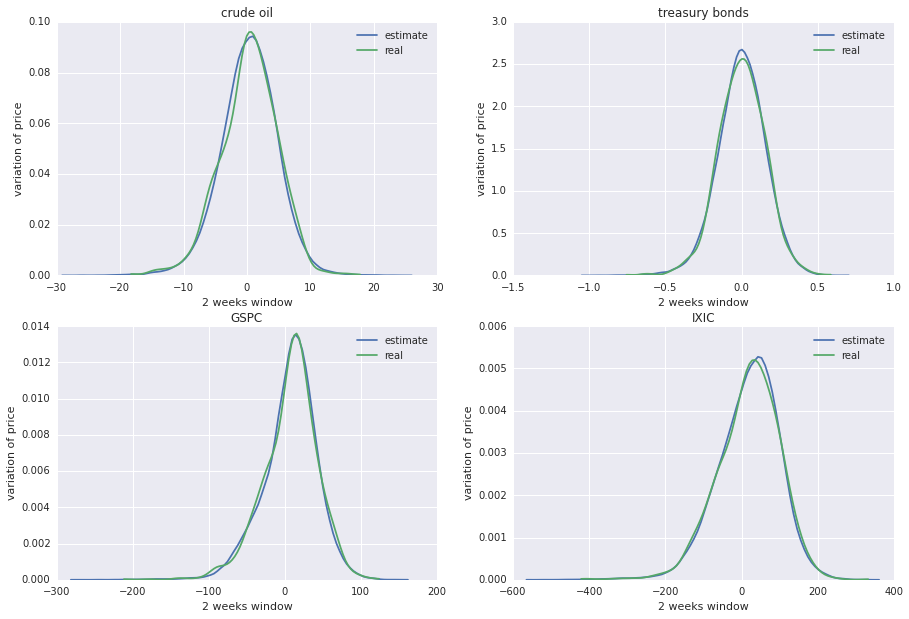

In [44]:
factorsNames = ["crude oil", "treasury bonds", "GSPC", "IXIC"] 
gmm = mixture.GMM(n_components=8, covariance_type='full',n_iter=1000,n_init=5)
gmm.fit(np.column_stack(factorsReturns))
results = gmm.sample(100000)
results = np.column_stack(results)

f, axarr = plt.subplots(2, 2)
f.set_figwidth(15)
f.set_figheight(10)
for (idx, factorReturn) in enumerate(factorsReturns):
    i, j = divmod(idx, 2)
    ax = axarr[i, j]
    
    domainEstimates, densityEstimates = plotDistribution(results[idx], show=False)
    domainFactor, densityFactor = plotDistribution(factorReturn, show=False)
    ax.plot(domainEstimates, densityEstimates)
    ax.plot(domainFactor, densityFactor)
    ax.set_title(factorsNames[idx])
    ax.set_xlabel("2 weeks window") 
    ax.set_ylabel("variation of price") 
    ax.legend(["estimate", "real"])

<div class="alert alert-success">
Using a gmm we note that we obtain a far better result.
We think that it is important to choose a model that can capture all the different components at the same time rather than fitting each component separately. We are convinced of this because we have seen an high correlation in our features and treating them as independent seems wrong.
</div>

### Step 3&4: Generating samples, running simulation and calculating the VaR

We define some functions that helps us calculating VaR 5%. You will see that the functions below are pretty complicated! This is why we provide a solution for you: however, study them well!!

The basic idea of calculating VaR 5% is that we need to find a value such that only 5% of the losses are bigger than it. That means the 5th percentile of the losses should be VaR 5%.

VaR can sometimes be problematic though, since it does give any information on the extent of the losses which can exceed the VaR estimate. CVar is an extension of VaR that is introduced to deal with this problem. Indeed, CVaR measures the expected value of the loss in those cases where VaR estimate has been exceeded.

In [45]:
a = [1,2]
np.max(a)

2

In [46]:
def fivePercentVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return topLosses[-1]

# an extension of VaR
def fivePercentCVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return sum(topLosses)/len(topLosses)

def bootstrappedConfidenceInterval(
      trials, computeStatisticFunction,
      numResamples, pValue):
    stats = []
    for i in range(0, numResamples):
        resample = trials.sample(True, 1.0)
        stats.append(computeStatisticFunction(resample))
    sorted(stats)
    lowerIndex = int(numResamples * pValue / 2 - 1)
    upperIndex = int(np.ceil(numResamples * (1 - pValue / 2)))
    return (stats[lowerIndex], stats[upperIndex])

Next, we will run the Monte Carlo simulation 10,000 times, in parallel using Spark. Since your cluster has 12 cores (two Spark worker nodes, each with 6 cores), we can set `parallelism = 12` to dispatch simulation on these cores, across the two machines (remember, those are not really "physical machines", they are Docker containers running in our infrastructure).

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 7
<div class="alert alert-info">
Complete the code below to define the simulation process and calculate VaR 5%.
</div>

```python
# RUN SILMULATION
def simulateTrialReturns(numTrials, factorMeans, factorCov, weights):
    trialReturns = []
    for i in range(0, numTrials):
        # generate sample of factors' returns
        trialFactorReturns = ...
        
        # featurize the factors' returns
        trialFeatures = ...
        
        # insert weight for intercept term
        trialFeatures.insert(0,1)
        
        trialTotalReturn = 0
        
        # calculate the return of each instrument
        # then calulate the total of return for this trial features
        trialTotalReturn = ...
        
        trialReturns.append(trialTotalReturn)
    return trialReturns


        
parallelism = 12
numTrials = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    ..., ...,
                    ...
                ))
trials.cache()

valueAtRisk = fivePercentVaR(...)
conditionalValueAtRisk = fivePercentCVaR(...)

print "Value at Risk(VaR) 5%:", valueAtRisk
print "Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk
```

In [47]:
# RUN SILMULATION
def simulateTrialReturns(numTrials, factorMeans, factorCov, weights):
    trialReturns = []
    for i in range(0, numTrials):
        # generate sample of factors' returns
        trialFactorReturns = np.random.multivariate_normal(factorMeans, factorCov)
        
        # featurize the factors' returns
        trialFeatures = featurize(trialFactorReturns)
        
        # insert weight for intercept term
        trialFeatures.insert(0,1)
        
        trialTotalReturn = 0
        
        # calculate the return of each instrument
        # then calulate the total of return for this trial features
        trialTotalReturn += sum([sum([weight[feature] * trialFeatures[feature] for feature in range(len(trialFeatures))]) for weight in weights])

        
        trialReturns.append(trialTotalReturn)
    return trialReturns


parallelism = 12
numTrials = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans, factorCov,
                    bFactorWeights.value
                ))

valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

print ("Value at Risk(VaR) 5%:", valueAtRisk)
print ("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)

Value at Risk(VaR) 5%: -17.8122890729
Conditional Value at Risk(CVaR) 5%: -24.5253826688


<div class="alert alert-success">
We calculated a Var at 5% of -18, this means that in 2 weeks we have a 5% probability to loose more than \$17.8 if we do not trade.
</div>

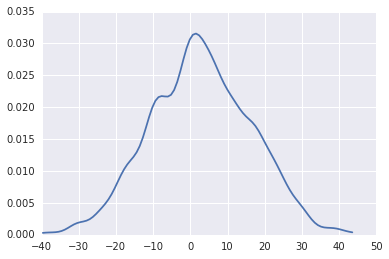

In [48]:
plotDistribution(trials.collect())

<div class="alert alert-success">
We can appreciate the high variance of the process, this means that we should make an high number of trials because otherwise we might sample some corner cases.
</div>

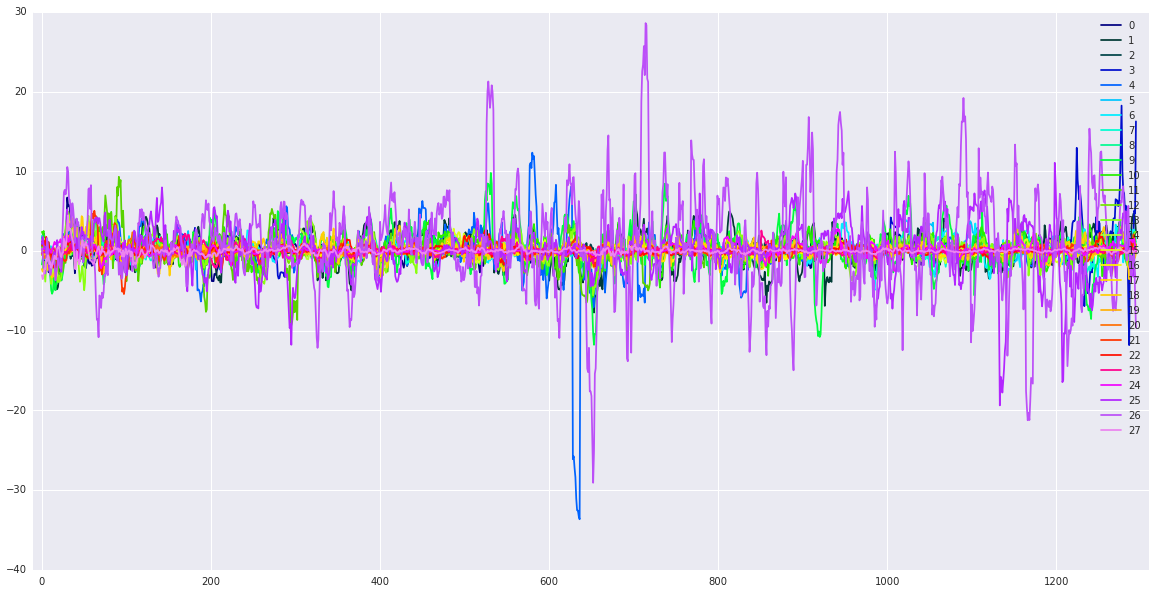

In [49]:
num_plots = len(stocksReturns)
plt.figure(figsize = (20,10))
# Have a look at the colormaps here and decide which one you'd like:
# http://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])

for stock in stocksReturns:
    plt.plot(stock)
plt.xlim(-10,1310)
plt.legend(range(len(stocksReturns)))
plt.show()

<div class="alert alert-success">
We can see that most of the stocks have the same pattern regarding the 2 weeks return. There are also some stocks that have a very high variability.
</div>

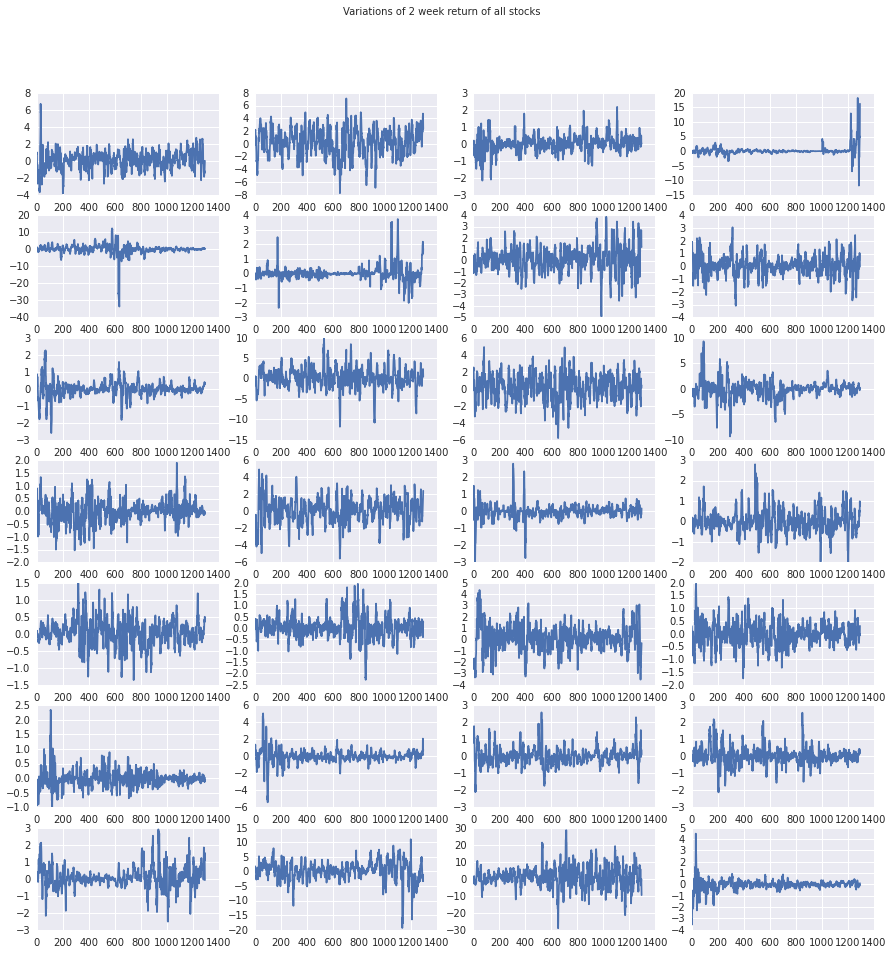

In [50]:
nCols = 4
nRows = int(np.ceil(len(stocksReturns)/nCols))
f , axarr = plt.subplots(nRows, nCols)
f.suptitle("Variations of 2 week return of all stocks")
f.set_figwidth(15)
f.set_figheight(15)
for idx, stockReturn in enumerate(stocksReturns):
    i, j = divmod(idx, nCols)
    ax = axarr[i, j]
    ax.plot(stockReturn)
f.subplots_adjust(hspace=0.2)

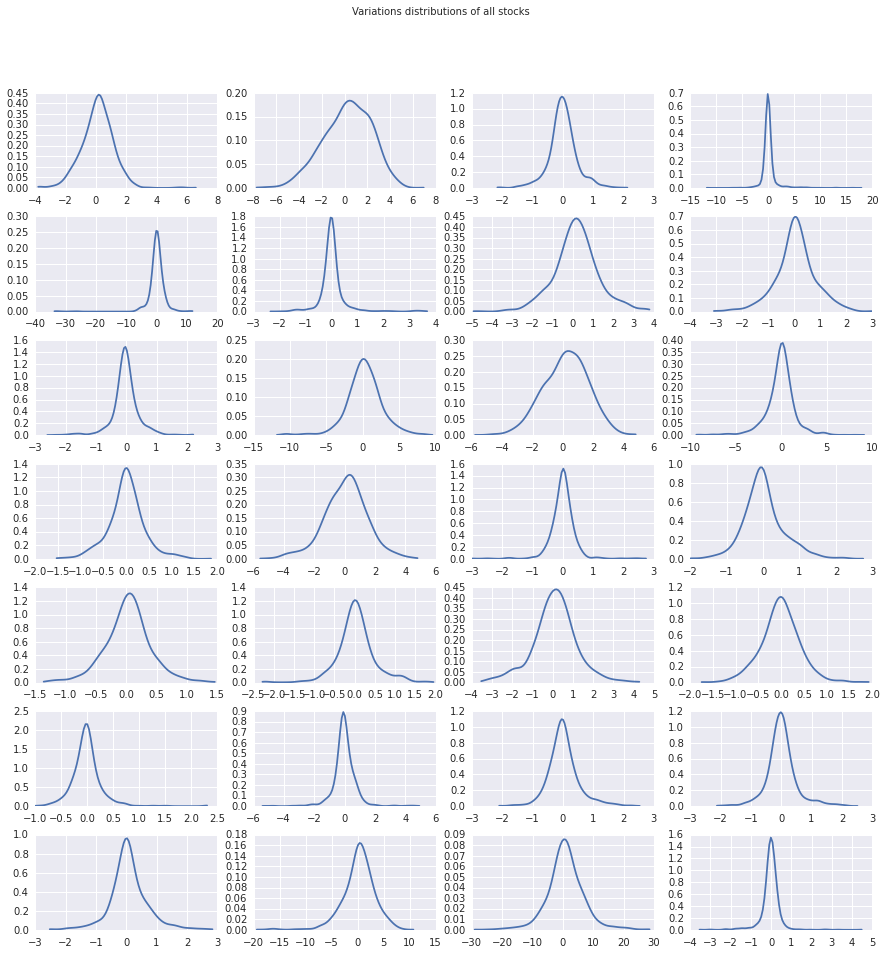

In [51]:
nCols = 4
nRows = int(np.ceil(len(stocksReturns)/nCols))
f , axarr = plt.subplots(nRows, nCols)
f.suptitle("Variations distributions of all stocks")
f.set_figwidth(15)
f.set_figheight(15)
for idx, stockReturn in enumerate(stocksReturns):
    i, j = divmod(idx, nCols)
    ax = axarr[i, j]
    domain, density = plotDistribution(stockReturn, show=False)
    ax.plot(domain, density)
f.subplots_adjust(hspace=0.3)

<div class="alert alert-success">
Here we can better appreciate the sample distribution of each stock 2 week return.
<br>
They are all gaussians, this can means that a model based on gaussians can be a good choice. Then, looking at their shape, we see that some have a very high variance, while others have a low variance, which means that values are more stable. In order to maximize the return, we need to model both.
</div>

The value of VaR depends on how many invested stocks and the chosen distribution of random variables. Assume that we get VaR 5% = -2.66,  that means that there is a 0.05 probability that the portfolio will fall in value by more than \$2.66 over a two weeks' period if there is no trading. In other words, the loses are less than \$2.66 over two weeks' period with 95% confidence level. When a loss over two weeks is more than \$2.66, we call it **failure** (or **exception**). Informally, because of 5% probability, we expect that there are only $0.05*W$ failures out of total $W$ windows.

todo: check how value variance changes with numtrials

### Step 5: Evaluating the results using backtesting method
In general, the error in a Monte Carlo simulation should be proportional to 1/sqrt(n), where n is the number of trials. This means, for example, that quadrupling the number of trials should approximately cut the error in half. A good way to check the quality of a result is backtesting on historical data. Backtesting is a statistical procedure where actual losses are compared to the estimated VaR. For instance, if the confidence level used to calculate VaR is 95% (or VaR 5%), we expect only 5 failures over 100 two-week time windows.

The most common test of a VaR model is counting the number of VaR failures, i.e., in how many windows, the losses exceed VaR estimate. If the number of exceptions is less than selected confidence level would indicate, the VaR model overestimates the risk. On the contrary, if there are too many exceptions, the risk is underestimated. However, it's very hard to observe the amount of failures suggested by the confidence level exactly. Therefore, people try to study whether the number of failures is reasonable or not, or will the model be accepted or rejected.

One common test is Kupiec's proportion-of-failures (POF) test. This test considers how the portfolio performed at many historical time intervals and counts the number of times that the losses exceeded the VaR. The null hypothesis is that the VaR is reasonable, and a sufficiently extreme test statistic means that the VaR estimate does not accurately describe the data. The test statistic is computed as:

$$
-2ln\Bigg(\frac{(1-p)^{T-x}p^x}{(1-\frac{x}{T})^{T-x}(\frac{x}{T})^x}\Bigg)
$$

where:

$p$ is the quantile-of-loss of the VaR calculation (e.g., in VaR 5%, p=0.05),

$x$ (the number of failures) is the number of historical intervals over which the losses exceeded the VaR 

$T$ is  the total number of historical intervals considered

Or we can expand out the log for better numerical stability:

$$
\begin{equation}
-2\Big((T-x)ln(1-p)+x*ln(p)-(T-x)ln(1-\frac{x}{T})-x*ln(\frac{x}{T})\Big)
\end{equation}
$$

If we assume the null hypothesis that the VaR is reasonable, then this test statistic is drawn from a chi-squared distribution with a single degree of freedom. By using Chi-squared distribution, we can find the `p-value` accompanying our test statistic value.  If `p-value` exceeds the critical value of the Chi-squared distribution, we do have sufficient evidence to reject the null hypothesis that the model is reasonable. Or we can say, in that case, the model is considered as inaccurate.

For example, assume that we calculate VaR 5% (the confidence level of the VaR model is 95%) and get value VaR = 2.26. We also observed 50 exceptions over 500 time windows. Using the formula above, the test statistic `p-value` is calculated and equal to `8.08`. Compared to `3.84`, the critical value of Chi-squared distribution with one degree of freedom at probability 5%, the test statistic is larger. So, the model is rejected. The critical values of Chi-squared can be found by following [this link](https://people.richland.edu/james/lecture/m170/tbl-chi.html).
However, in this Notebook, it's not a good idea to find the corresponding critical value by looking in a "messy" table, especially when we need to change the confidence level. Instead, from `p-value`, we will calculate the probability of the test statistic in Chi-square thanks to some functions in package `scipy`. If the calculated probability is smaller than the quantile of loss (e.g, 0.05), the model is rejected and vice versa.


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 8

#### Question 8.1
<div class="alert alert-info">

Write a function to calculate the number of failures, that is when the losses (in the original data) exceed the VaR.

</div>

<div class="label label-success">HINT</div>
<ul>
  <li>First, we need to calculate the total loss in each 2-week time interval</li>
  <li>If the total loss of a time interval exceeds VaR, then we say that our VaR fails to estimate the risk in that time interval</li>
  <li>Return the number of failures</li>
</ul>  

<div class="label label-danger">NOTE</div> The loss is often having negative value, so, be careful when compare it to VaR.

```python
from scipy import stats
import math

def countFailures(stocksReturns, valueAtRisk):
    failures = 0
    # iterate over time intervals
    for i in range(0, ...):
        # calculate the losses in each time interval
        loss = ...
        
        # if the loss exceeds VaR
        if ...:
            failures += 1
    return failures
```

In [52]:
from scipy import stats
import math

def countFailures(stocksReturns, valueAtRisk):
    failures = 0
    windows = [list(window) for window in zip(*stocksReturns)]
    losses = map(lambda x: sum(x),windows)
    # iterate over time intervals
    for loss in losses:
        # if the loss exceeds VaR
        if loss < valueAtRisk:
            failures += 1
    return failures

In [53]:
countFailures(stocksReturns,valueAtRisk)

127

#### Question 8.2
<div class="alert alert-info">

Write a function named `kupiecTestStatistic` to calculate the test statistic which was described in the above equation.

</div>

```python
def kupiecTestStatistic(total, failures, confidenceLevel):
    failureRatio = .../...
    logNumer = ...
    logDenom = ...
    return -2 * (logNumer - logDenom)
    
# test the function
assert (round(kupiecTestStatistic(250, 36, 0.1), 2) == 4.80), "function kupiecTestStatistic runs incorrectly"
```

In [54]:
def kupiecTestStatistic(total, failures, confidenceLevel):
    failureRatio = failures/total
    logNumer = (total-failures) * np.log(1-confidenceLevel) + failures * np.log(confidenceLevel)
    logDenom = (total-failures) * np.log(1-failureRatio) + failures * np.log(failureRatio)
    return -2 * (logNumer - logDenom)
    
# test the function
assert (round(kupiecTestStatistic(250, 36, 0.1), 2) == 4.80), "function kupiecTestStatistic runs incorrectly"

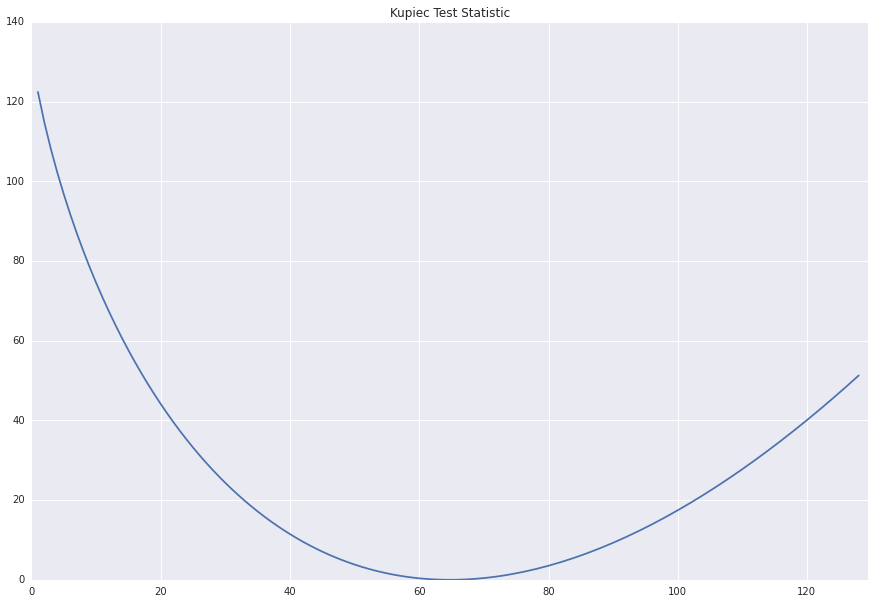

In [160]:
p = 0.05
stocklen = len(stocksReturns[0])
x = np.arange(0, T, 1)
y = list(map(lambda x: kupiecTestStatistic(stocklen, x, p), x))
f, (ax1) = plt.subplots(1, 1)
f.set_figwidth(15)
f.set_figheight(10)

ax1.set_title("Kupiec Test Statistic")
ax1.set_xlim(0, stocklen*0.1)
ax1.plot(x[:int(stocklen*0.1)], y[:int(stocklen*0.1)])

print()

<div class="alert alert-success">
The minimum value of the KupiecTestStatistic is reached when the number of failures is equal to the number of trials multiplied the target confidence value, the function is very low around the min but vary a lot in the boundaries.
<br>
For now, we obtain 127 failures, which are way far from the expected number of failures, which is 65. This means that our model is flawed.
</div>

Now we can find the p-value accompanying our test statistic value.

In [56]:
def kupiecTestPValue(stocksReturns, valueAtRisk, confidenceLevel):
    failures = countFailures(stocksReturns, valueAtRisk)
    print("num failures:", failures)
    if failures == 0:
        # the model is very good
        return 1
    total = len(stocksReturns[0])
    testStatistic = kupiecTestStatistic(total, failures, confidenceLevel)
    #return 1 - stats.chi2.cdf(testStatistic, 1.0)
    return stats.chi2.sf(testStatistic, 1.0)

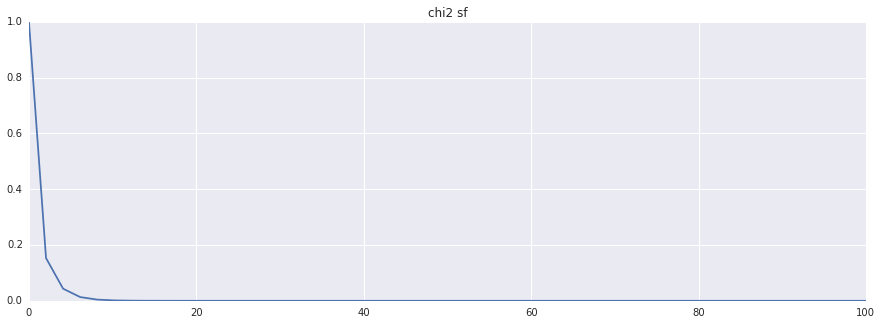

In [57]:
plt.figure(figsize = (15,5))
x = np.linspace(0,  100)
plt.plot(x, stats.chi2.sf(x, 1.0))
plt.title("chi2 sf")
plt.show()


In [58]:
varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, 0.05)
print("VaR confidence interval: " , varConfidenceInterval)
print("CVaR confidence interval: " , cvarConfidenceInterval)
print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, valueAtRisk, 0.05))

VaR confidence interval:  (-20.478498460101999, -20.09025166144238)
CVaR confidence interval:  (-23.661359025522277, -24.883764887132298)
num failures: 127
Kupiec test p-value:  1.69180929189e-12


#### Question 8.3
<div class="alert alert-info">

Discuss the results you have obtained

</div>

<div class="alert alert-success">
The failure rate is definetly not close to 5%, in fact we obtain 165 failures out of 1295 trials. This is confirmed by the Kupiec test p-value, which is very low.</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 9
<div class="alert alert-info">
Assume that we invest in more than 100 stocks. Use the same market factors as for the previous questions to estimate VaR by running MCS, then validate your result.  

What is the main observation you have, once you answer this question? When you plan to invest in more instruments, how is your ability to predict the risk going to be affected?
</div>


todo: check correctness

In [59]:
def RunAll(numberOfFiles,
             start = datetime(year=2009, month=1, day=23),
             end = datetime(year=2014, month=1, day=23),
             number_of_years = 5):

    # select path of all stock data files in "stock_folder"
    files = [join(stock_folder, f) for f in listdir(stock_folder) if isfile(join(stock_folder, f))]

    files = files[:numberOfFiles]
    # read each line in each file, convert it into the format: (date, value)
    rawStocks = [process_stock_file(f) for f in files]

    # select only instruments which have more than 5 years of history
    # Note: the number of business days in a year is 260
    number_of_years = 5
    rawStocks = list(filter(lambda instrument : len(instrument)>= 260*number_of_years  , rawStocks))
    rawStocks = list(filter(lambda instrument: instrument[0][0] <= start and instrument[-1][0] >= end , rawStocks))
    rawStocks = list(filter(lambda instrument: np.max(list([x for x in zip(*instrument)])[1]) < 10000 , rawStocks))
        
    stocks = list(map(lambda stock: \
                fillInHistory(
                    trimToRegion(stock, start, end), 
                start, end), 
            rawStocks))
    
    allfactors = factors1 + factors2
    #print(allfactors)
    factors = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
            allfactors
            ))
    #print(stocks[-1])
    
    stocksReturns = list(map(twoWeekReturns, stocks))
    
    #print(stocksReturns[-1])
    
    
    factorsReturns = list(map(twoWeekReturns, factors))
    
    factorCov = np.cov(factorsReturns)
    factorMeans = [np.sum(factorReturns)/len(factorReturns) for factorReturns in factorsReturns]
    print("number of factors: " + str(len(factorMeans)))
    # transpose factorsReturns
    factorMat = transpose(factorsReturns)

    # featurize each row of factorMat
    factorFeatures = list(map(featurize,factorMat))

    # OLS require parameter is a numpy array
    factor_columns = np.array(factorFeatures)

    #add a constant - the intercept term for each instrument i.
    factor_columns = sm.add_constant(factor_columns, prepend=True)
    
    # estimate weights
    weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns]

    print("number of weights:", len(weights))

    parallelism = 12
    numTrials = 100000
    trial_indexes = list(range(0, parallelism))
    seedRDD = sc.parallelize(trial_indexes, parallelism)
    bFactorWeights = sc.broadcast(weights)

    trials = seedRDD.flatMap(lambda idx: \
                    simulateTrialReturns(
                        max(int(numTrials/parallelism), 1), 
                        factorMeans, factorCov,
                        bFactorWeights.value
                    ))
    trials.cache()

    valueAtRisk = fivePercentVaR(trials)
    conditionalValueAtRisk = fivePercentCVaR(trials)

    print ("Value at Risk(VaR) 5%:", valueAtRisk)
    print ("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)

    #varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
    #cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
    failures = countFailures(stocksReturns, valueAtRisk)
    kupiec = kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)
    #print("VaR confidence interval: " , varConfidenceInterval)
    #print("CVaR confidence interval: " , cvarConfidenceInterval)
    print("Kupiec test p-value: " , kupiec)
    #return (len(weights),valueAtRisk,conditionalValueAtRisk,failures,kupiec)
    return (len(weights),valueAtRisk,conditionalValueAtRisk,failures,kupiec)

In [60]:
RunAll(50)

number of factors: 4
number of weights: 40
Value at Risk(VaR) 5%: -24.4735712771
Conditional Value at Risk(CVaR) 5%: -31.7820158415
num failures: 93
Kupiec test p-value:  0.00069672615601


(40, -24.473571277063932, -31.782015841471928, 93, 0.00069672615600983021)

In [61]:
results = []
for num_files in [25,50,100,200,400,800,1600,3200]:
    results.append(RunAll(num_files))

number of factors: 4
number of weights: 19
Value at Risk(VaR) 5%: -13.1948833197
Conditional Value at Risk(CVaR) 5%: -16.5823401225
num failures: 124
Kupiec test p-value:  1.49709713829e-11
number of factors: 4
number of weights: 40
Value at Risk(VaR) 5%: -24.8785462157
Conditional Value at Risk(CVaR) 5%: -32.658568008
num failures: 91
Kupiec test p-value:  0.00156249536725
number of factors: 4
number of weights: 69
Value at Risk(VaR) 5%: -43.9870347896
Conditional Value at Risk(CVaR) 5%: -56.6062369736
num failures: 92
Kupiec test p-value:  0.00104901548216
number of factors: 4
number of weights: 134
Value at Risk(VaR) 5%: -108.492032636
Conditional Value at Risk(CVaR) 5%: -136.983937031
num failures: 54
Kupiec test p-value:  0.158728377994
number of factors: 4
number of weights: 264
Value at Risk(VaR) 5%: -216.58907427
Conditional Value at Risk(CVaR) 5%: -278.966908129
num failures: 84
Kupiec test p-value:  0.018689333858
number of factors: 4
number of weights: 570
Value at Risk(VaR)

In [62]:
results_zip = [list(x) for x in zip(*results)]
print(results_zip)

[[19, 40, 69, 134, 264, 570, 1120, 1911], [-13.194883319650685, -24.878546215684342, -43.987034789588549, -108.49203263565889, -216.58907427042914, -420.08300317458679, -840.62869738733309, -1494.3120298825831], [-16.582340122484535, -32.658568008047887, -56.606236973634282, -136.98393703149011, -278.96690812892729, -543.63417485443892, -1082.3855220177543, -1915.1085255510959], [124, 91, 92, 54, 84, 90, 86, 80], [1.4970971382916519e-11, 0.0015624953672465282, 0.0010490154821613416, 0.15872837799410078, 0.018689333857969618, 0.0023022019477930895, 0.0097220999051757864, 0.060315345229939879]]


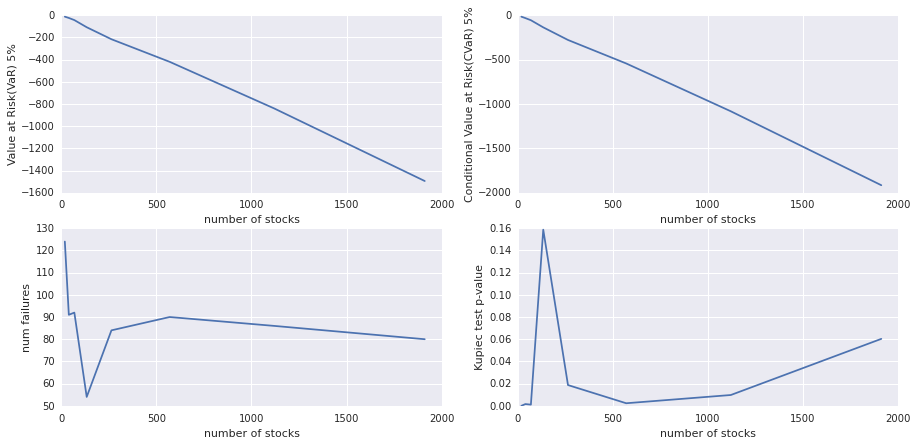

In [63]:
factor_names = ["Value at Risk(VaR) 5%", "Conditional Value at Risk(CVaR) 5%", "num failures", "Kupiec test p-value"] 
f, axarr = plt.subplots(2, 2)
f.set_figwidth(15)
f.set_figheight(7)
for (idx,value) in enumerate(results_zip[1:]):
    i, j = divmod(idx, 2)
    ax = axarr[i, j]
    ax.plot(results_zip[0],value)
    ax.set_ylabel(factor_names[idx])
    ax.set_xlabel("number of stocks") 


<div class="alert alert-success">
From the first two plots, it's clear that the value at risk is proportional to the number of stocks.
<br>
That is a nice observation, because we thought that with more stocks, we were able to get better results and average bad results, but apparently we were wrong.
<br>
Looking at the number of failures, we see that it drops when we have from 50 to 200 stocks and then it increases again. This can be explained from the fact that not all stocks are the same, and maybe the first ones are better with our model. We think that with more stocks, the model is less affected from peaks and drops of the markets.
<br>
The best kupiec p-value better is observed when we have 200 stocks, but then it drops again.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 10
<div class="alert alert-info">

In the previous questions, we used the normal distributions to sample the factors returns.  

Try to study how results vary when selecting other probability distributions: our goal is to improve the result of our MCS.
</div>

## Gaussian Mixture Model

In [64]:
# RUN SILMULATION
def simulateTrialReturns_gmm(numTrials, weights, model):
    trialReturns = []
    
    for i in range(0, numTrials):
        # generate sample of factors' returns
        trialFactorReturns = model.sample(1)[0]
        
        # featurize the factors' returns
        trialFeatures = featurize(trialFactorReturns)
        
        # insert weight for intercept term
        trialFeatures.insert(0,1)
        
        trialTotalReturn = 0
        
        # calculate the return of each instrument
        # then calulate the total of return for this trial features
        trialTotalReturn += sum([sum([weight[feature] * trialFeatures[feature] for feature in range(len(trialFeatures))]) for weight in weights])

        
        trialReturns.append(trialTotalReturn)
    return trialReturns

In [65]:
def RunAll_gmm(numberOfFiles,
             start = datetime(year=2009, month=1, day=23),
             end = datetime(year=2014, month=1, day=23),
             number_of_years = 5, components = 8):

    # select path of all stock data files in "stock_folder"
    files = [join(stock_folder, f) for f in listdir(stock_folder) if isfile(join(stock_folder, f))]

    files = files[:numberOfFiles]
    # read each line in each file, convert it into the format: (date, value)
    rawStocks = [process_stock_file(f) for f in files]

    # select only instruments which have more than 5 years of history
    # Note: the number of business days in a year is 260
    number_of_years = 5
    rawStocks = list(filter(lambda instrument : len(instrument)>= 260*number_of_years  , rawStocks))
    rawStocks = list(filter(lambda instrument: instrument[0][0] <= start and instrument[-1][0] >= end , rawStocks))
    rawStocks = list(filter(lambda instrument: np.max(list([x for x in zip(*instrument)])[1]) < 10000 , rawStocks))
        
    stocks = list(map(lambda stock: \
                fillInHistory(
                    trimToRegion(stock, start, end), 
                start, end), 
            rawStocks))
    
    allfactors = factors1 + factors2
    #print(allfactors)
    factors = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
            allfactors
            ))

    stocksReturns = list(map(twoWeekReturns, stocks))

    factorsReturns = list(map(twoWeekReturns, factors))
    
    factorCov = np.cov(factorsReturns)
    factorMeans = [np.sum(factorReturns)/len(factorReturns) for factorReturns in factorsReturns]
    print("number of factors: " + str(len(factorMeans)))
    # transpose factorsReturns
    factorMat = transpose(factorsReturns)

    # featurize each row of factorMat
    factorFeatures = list(map(featurize,factorMat))

    # OLS require parameter is a numpy array
    factor_columns = np.array(factorFeatures)

    #add a constant - the intercept term for each instrument i.
    factor_columns = sm.add_constant(factor_columns, prepend=True)
    
    # estimate weights
    weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns]

    model = mixture.GMM(n_components=components, covariance_type='full',n_iter=1000,n_init=5)
    model.fit(np.column_stack(factorsReturns))
    

    print("number of weights:", len(weights))

    parallelism = 12
    numTrials = 100000
    trial_indexes = list(range(0, parallelism))
    seedRDD = sc.parallelize(trial_indexes, parallelism)
    bFactorWeights = sc.broadcast(weights)

    trials = seedRDD.flatMap(lambda idx: \
                    simulateTrialReturns_gmm(
                        max(int(numTrials/parallelism), 1), 
                        bFactorWeights.value,
                        model
                    ))
    trials.cache()

    valueAtRisk = fivePercentVaR(trials)
    conditionalValueAtRisk = fivePercentCVaR(trials)

    print ("Value at Risk(VaR) 5%:", valueAtRisk)
    print ("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)

    #varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
    #cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
    failures = countFailures(stocksReturns, valueAtRisk)
    kupiec = kupiecTestPValue(stocksReturns, valueAtRisk, 0.05)
    #print("VaR confidence interval: " , varConfidenceInterval)
    #print("CVaR confidence interval: " , cvarConfidenceInterval)
    #print("Kupiec test p-value: " , kupiec)
    #return (len(weights),valueAtRisk,conditionalValueAtRisk,failures,kupiec)
    return (len(weights),valueAtRisk,conditionalValueAtRisk,failures,kupiec,components)

## optimize the gmm model

<div class="alert alert-success">
We want to find the number of components that optimizes our model.
</div>


In [70]:
results_gmm = []
for num_files in [25,50,100,200,400,800,1600,3200]:
    for components in [4,8,25,50,100]:
        results_gmm.append(RunAll_gmm(num_files,components=components))

number of factors: 4
number of weights: 19
Value at Risk(VaR) 5%: -14.5537401504
Conditional Value at Risk(CVaR) 5%: -20.480129159
num failures: 98
number of factors: 4
number of weights: 19
Value at Risk(VaR) 5%: -13.9911270542
Conditional Value at Risk(CVaR) 5%: -19.9782594576
num failures: 108
number of factors: 4
number of weights: 19
Value at Risk(VaR) 5%: -14.4921059945
Conditional Value at Risk(CVaR) 5%: -19.884441214
num failures: 99
number of factors: 4
number of weights: 19
Value at Risk(VaR) 5%: -14.0368429385
Conditional Value at Risk(CVaR) 5%: -19.769081825
num failures: 108
number of factors: 4
number of weights: 19
Value at Risk(VaR) 5%: -14.0418900872
Conditional Value at Risk(CVaR) 5%: -20.0071002592
num failures: 108
number of factors: 4
number of weights: 40
Value at Risk(VaR) 5%: -27.4075783244
Conditional Value at Risk(CVaR) 5%: -41.3673115444
num failures: 72
number of factors: 4
number of weights: 40
Value at Risk(VaR) 5%: -26.3205459663
Conditional Value at Risk

In [72]:
import csv
with open('gmm.csv', "w") as file:
    writer = csv.writer(file)
    for row in results_gmm:
        writer.writerow([num for num in row])

In [73]:
results_gmm = []
import csv
with open('gmm.csv', "r") as file:
    reader = csv.reader(file)
    for row in reader:
        results_gmm.append(row)

In [74]:
results_components = {}
components = set([x[5] for x in results_gmm])

In [75]:
components

{'100', '25', '4', '50', '8'}

In [76]:
for x in components:
    results_components[x] = []

In [77]:
for x in results_gmm:
    results_components[x[5]].append(x)

In [78]:
results_components['8']

[['19', '-13.9911270542', '-19.9782594576', '108', '4.32481037907e-07', '8'],
 ['40', '-26.3205459663', '-39.8533160289', '78', '0.101199378449', '8'],
 ['69', '-46.5100828784', '-67.7921937985', '81', '0.0457738831779', '8'],
 ['134', '-112.780612285', '-157.033655896', '48', '0.0254781986377', '8'],
 ['264', '-229.363112134', '-347.937684364', '77', '0.128856308548', '8'],
 ['570', '-440.928216248', '-656.980733952', '83', '0.0254791443177', '8'],
 ['1120', '-894.303724955', '-1305.5596419', '75', '0.201869186396', '8'],
 ['1911', '-1588.36847073', '-2276.78513676', '64', '0.923677398232', '8']]

In [79]:
results_components.keys()

dict_keys(['4', '25', '8', '100', '50'])

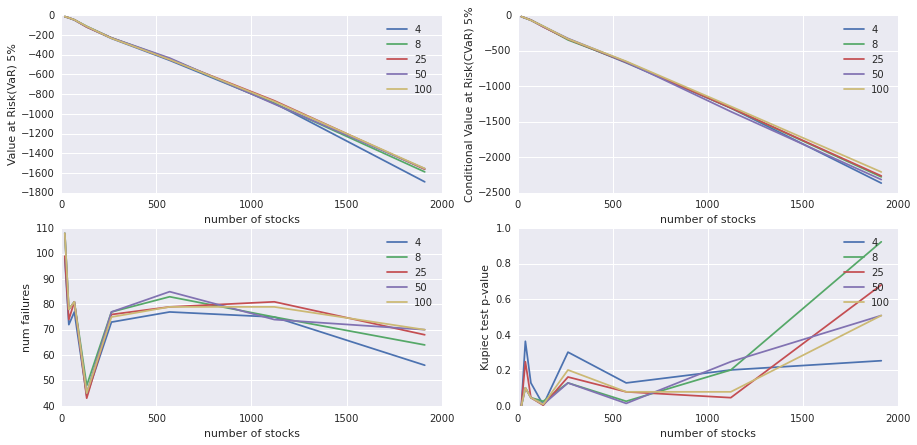

In [80]:
factor_names = ["Value at Risk(VaR) 5%", "Conditional Value at Risk(CVaR) 5%", "num failures", "Kupiec test p-value"] 
f, axarr = plt.subplots(2, 2)
f.set_figwidth(15)
f.set_figheight(7)
for (idx,name) in enumerate(factor_names):
    i, j = divmod(idx, 2)
    ax = axarr[i, j]
    ax.set_ylabel(factor_names[idx])
    ax.set_xlabel("number of stocks") 
    for component in sorted(results_components,key= lambda x: int(x)):
        results_zip = list([x for x in zip(*results_components[component])])
        ax.plot(results_zip[0],results_zip[idx+1])
    ax.legend(sorted(results_components.keys(),key= lambda x: int(x)))

<div class="alert alert-success">
We note that using gmm we obtain far better results, in fact we see that the number of failures is near 65 and the kupiec value is near 1 in some cases. So we can affirm that the gmm model is batter than the original one.
</div>


<div class="alert alert-success">
Speaking about the number of components, we see that we obtain the best results with a low number of components.
</div>


# 6. Summary
In this lecture, we studied the Monte Carlo Simulation method and its application to estimate financial risk. To apply it, first, we needed to define the relationship between market factors and the instruments' returns. In such step, you must define the model which maps the market factors' values to the instruments' values: in our use case, we used a linear regression function for building our model. Next, we also had to find the parameters of our model, which are the weights of the factors we considered. Then, we had to study the distribution of each market factor. A good way to do that is using Kernel density estimation to smooth the distribution and plot it. Depending on the shape of each figure, we had to guess the best fit distribution for each factor: in our use case, we used a very simple approach, and decided that our smoothed distributions all looked normal distributions. 

Then, the idea of Monte Carlo simulation was to generate many possible values for each factor and calculate the corresponding outcomes by a well-defined model in each trial. After many trials, we were able to calculate VaR from the sequences of outcome's values. When the number of trials is large enough, the VaR converges to reasonable values, that we could validate using well-known statistical hypothesis. 

# References
- The example in section 2 is inspired from [this article](http://www.solver.com/monte-carlo-simulation-example).
- [Backtesting Value-at-Risk models](https://aaltodoc.aalto.fi/bitstream/handle/123456789/181/hse_ethesis_12049.pdf?sequence=1) (Kansantaloustiede, 2009) - (A good reference to study Backtesting).


# Adding more factors

<div class="alert alert-success">
Using the "investing.com" site,we have retireved other market factors. However we have not a big experience about the financial world so we have based our choiche lookink at the site www.investopedia.com. 
At the end we've chosen these parameters:
<ul>
  <li>EUR/USD - Euro US Dollar</li>
  <li>Gold Futures (GCM7)</li>
  <li>IQ Real Return (CPI)</li>
  <li>Silver Futures (SIN7)</li>
</ul>
<br>
Let's load the new factors!
</div>


In [81]:
additional_factors_files = ['EUR_USD.tsv', 'GCM7.tsv','CPI.tsv','SIN7.tsv']
additional_factors = map(lambda fn: factors_folder + fn, additional_factors_files)
factors3 = [readInvestingDotComHistory(f) for f in additional_factors]

In [82]:
allfactors = factors1 + factors2 + factors3

factors = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
            allfactors
            ))

factorsReturns = list(map(twoWeekReturns, factors))

factorMat = transpose(factorsReturns) 
factorFeatures = list(map(featurize,factorMat))
factor_columns = np.array(factorFeatures)
factor_columns = sm.add_constant(factor_columns, prepend=True)
weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns] 

<div class="alert alert-success">
Also in this case, we use a normal distribution to sample the new factors returns.
</div>

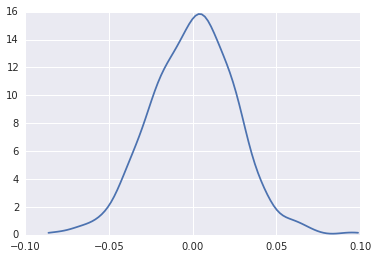

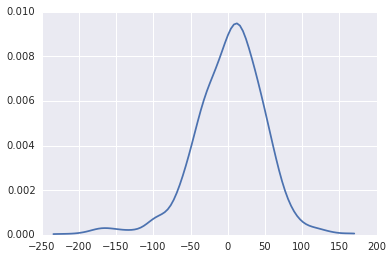

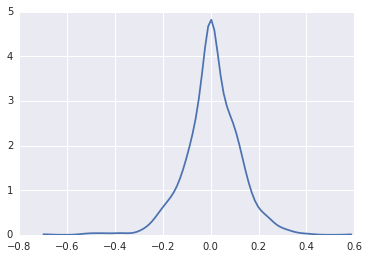

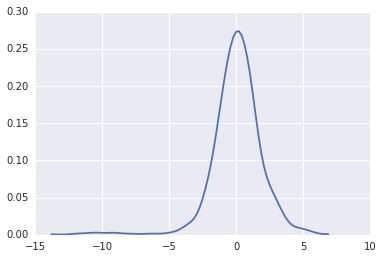

In [83]:
plotDistribution(factorsReturns[4])
plotDistribution(factorsReturns[5])
plotDistribution(factorsReturns[6])
plotDistribution(factorsReturns[7])

<div class="alert alert-success">
Remebering that this approach ignores the correlection between factors, we want to understand how much the new factors are correlated with the old ones.
</div>

In [84]:
correlation = np.corrcoef(factorsReturns)
print(correlation)


[[ 1.          0.38507954  0.414966    0.44278612  0.41132179  0.26537407
   0.19952837  0.44582751]
 [ 0.38507954  1.          0.46210122  0.49911941  0.25269764 -0.03689523
  -0.2082915   0.15467508]
 [ 0.414966    0.46210122  1.          0.92053356  0.36922369  0.10572621
   0.21209538  0.23402876]
 [ 0.44278612  0.49911941  0.92053356  1.          0.36451774  0.11841743
   0.20890699  0.25929435]
 [ 0.41132179  0.25269764  0.36922369  0.36451774  1.          0.27518612
   0.19860072  0.34073397]
 [ 0.26537407 -0.03689523  0.10572621  0.11841743  0.27518612  1.
   0.57638101  0.74152106]
 [ 0.19952837 -0.2082915   0.21209538  0.20890699  0.19860072  0.57638101
   1.          0.40239091]
 [ 0.44582751  0.15467508  0.23402876  0.25929435  0.34073397  0.74152106
   0.40239091  1.        ]]


<div class="alert alert-success">
Looking at the correlation matrix above, we can see that the new factors don't seem very correlated with the old ones.
In the graph bwlow, we can have a best visualization of the correlation.
</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


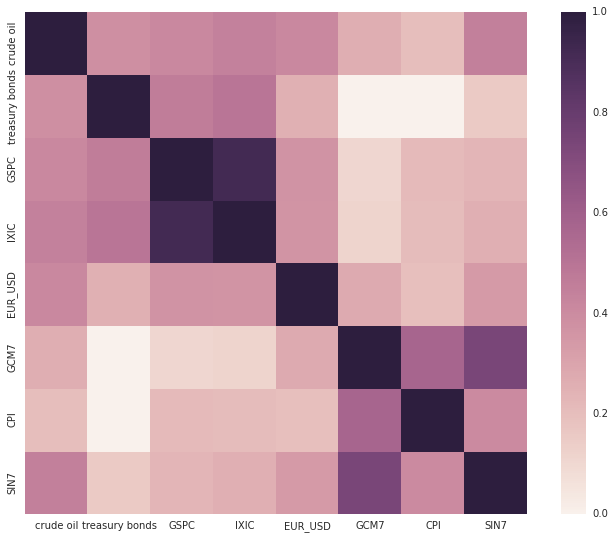

In [85]:
factor_names = ["crude oil", "treasury bonds", "GSPC", "IXIC"] 
additional_names = [x.replace('.tsv','') for x in  additional_factors_files]
new_factor_names = factor_names + additional_names
f = plt.subplots(figsize=(12, 9))
ax = sns.heatmap(correlation, vmin=0, vmax=1, square=True)
ax.set(xticklabels=new_factor_names,yticklabels=new_factor_names[::-1])
print()

<div class="alert alert-success">
As we can see, except for the correlation between IQ Real Return (CPI) and Gold Futures (GCM7), and the correlation between Gold Futures (GCM7) and Silver Futures(SIN7),  the correlation values related to the new market factors are low, excpecially the ones between the new factors and the old ones. This sounds good, but doesn't indicate that these are good factors for sure. The only way to be sure about this is to test if the quality of our model improves, adding these factors. 
</div>

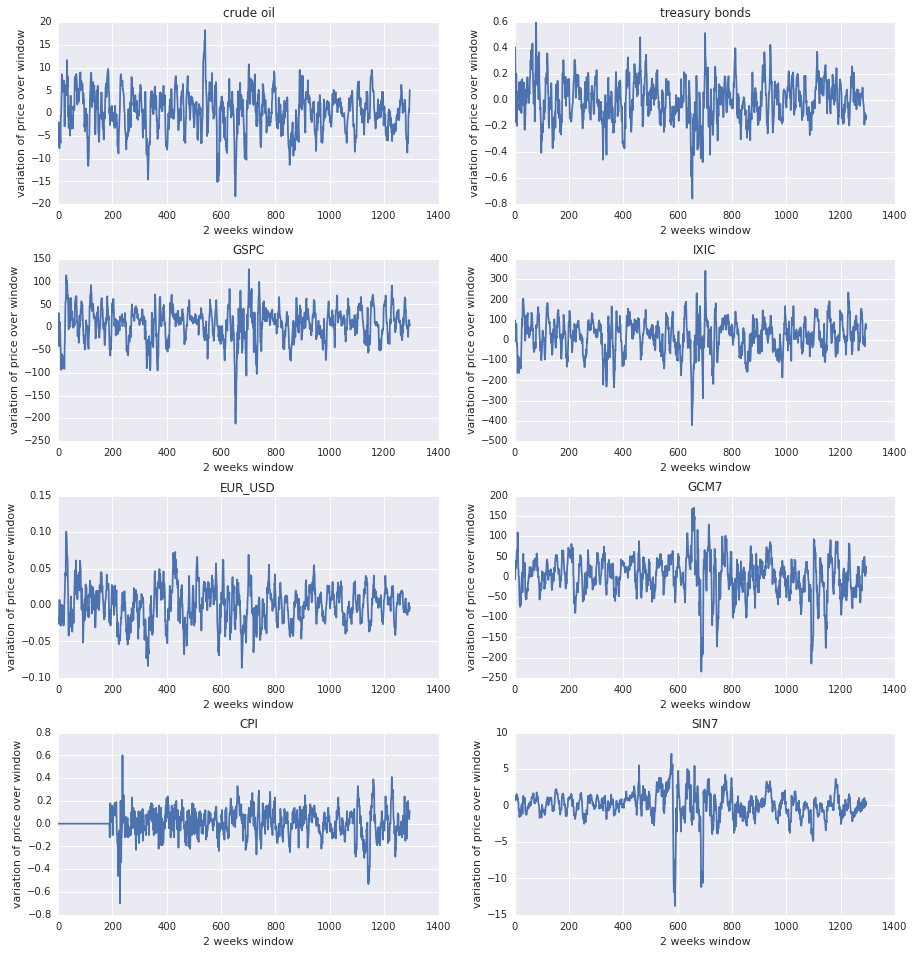

In [86]:
plotVariation(new_factor_names)

<div class="alert alert-success">
Plotting the variation of our new factors, we noted that for the IQ Real Return (CPI) there is one year missing. For this reason we decided to remove this factor. This should not be a big problem, also because it has an correlation of 0.4 about with Silver Futures (SIN7) and of 0.6 about with Gold Futures (GCM7). So it should nnot introduce a alot of information.
</div>

In [87]:
allfactors.remove(allfactors[6])
new_factor_names.remove(new_factor_names[6])

factors = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
            allfactors
            ))

factorsReturns = list(map(twoWeekReturns, factors))

factorMat = transpose(factorsReturns) 
factorFeatures = list(map(featurize,factorMat))
factor_columns = np.array(factorFeatures)
factor_columns = sm.add_constant(factor_columns, prepend=True)
weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns] 

In [88]:
factorCov = np.cov(factorsReturns)
factorMeans = [np.sum(factorReturns)/len(factorReturns) for factorReturns in factorsReturns]
sample = np.random.multivariate_normal(factorMeans, factorCov)

In [89]:
parallelism = 12
numTrials = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans, factorCov,
                    bFactorWeights.value
                ))

valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)
failures = countFailures(stocksReturns, valueAtRisk)
print ("Value at Risk(VaR) 5%:", valueAtRisk)
print ("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)
print ("failures: ", failures)

Value at Risk(VaR) 5%: -18.6574293413
Conditional Value at Risk(CVaR) 5%: -25.7623393517
failures:  115


<div class="alert alert-success">
Using all the factors we do not find any improvement regarding the value at risk or the number of failures, which should be near 65. Actually we are not finacial experts, so maybe the factors that we have considered are not the best ones. In this moment we are using 7 factors; however some of them are maybe unesufl or generate bad results. To understand the best combination of factor and knowing our ignorance about finacial world, we will try all differebnt combinations of features of every possible number of elements. We'll save all results in a file a we'll reason about this, keeping the best combination.
<br>
<br>
The code below, until the next comment, performs what we have descibed.
</div>

In [90]:
def run_all_1(factorMeans,factorCov,weights):
    parallelism = 12
    numTrials = 10000
    trial_indexes = list(range(0, parallelism))
    seedRDD = sc.parallelize(trial_indexes, parallelism)
    bFactorWeights = sc.broadcast(weights)

    trials = seedRDD.flatMap(lambda idx: \
                    simulateTrialReturns(
                        max(int(numTrials/parallelism), 1), 
                        factorMeans, factorCov,
                        bFactorWeights.value
                    ))

    valueAtRisk = fivePercentVaR(trials)
    conditionalValueAtRisk = fivePercentCVaR(trials)
    return valueAtRisk

In [91]:
def computeMontecarlo(choice,f_wr):
    factors = list(map(lambda stock: \
                fillInHistory(
                    trimToRegion(stock, start, end), 
                start, end), 
                choice
                ))

    factorsReturns = list(map(twoWeekReturns, factors))

    factorMat = transpose(factorsReturns) 
    factorFeatures = list(map(featurize,factorMat))
    factor_columns = np.array(factorFeatures)
    factor_columns = sm.add_constant(factor_columns, prepend=True)
    weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns]
    factorCov = np.cov(factorsReturns)
    factorMeans = [np.sum(factorReturns)/len(factorReturns) for factorReturns in factorsReturns]
    sample = np.random.multivariate_normal(factorMeans, factorCov)
    return run_all_1(factorMeans,factorCov,weights)

In [92]:
def choose_iter(elements, length):
    for i in range(len(elements)):
        if length == 1:
            yield (elements[i],)
        else:
            for next in choose_iter(elements[i+1:len(elements)], length-1):
                yield (elements[i],) + next
def choose(l, k):
    return list(choose_iter(l, k))

In [100]:
with open('results.txt','w+') as f_wr:
    tot = '0123456'
    for length in range(2,6):
        permutations = list(choose_iter(tot, length))
        for p in permutations:
            choice = []
            for i in p:
                choice.append(allfactors[int(i)])
            res = str(computeMontecarlo(choice,f_wr))
            f_wr.write("  ".join(p)+'|||'+res+'\n')

<div class="alert alert-success">
Now that we have tried all different combinations of factors and we have saved the results into "results.txt", we can loads them to try to understand which are the best ones.
</div>

In [101]:

with open('results.txt') as f_rd:
    all_lines = f_rd.readlines()

all_lines = [l[0:-1].split('|||') for l in all_lines]
all_lines = [(list(map(int, l[0].split("  "))),float(l[1])) for l in all_lines]


In [102]:
all_lines.sort(key=lambda x:x[1],reverse=True)

all_lines_with_failures = [l+(countFailures(stocksReturns, l[1]),) for l in all_lines]
print (all_lines_with_failures[0:4])

[([4, 6], -5.99335114024, 359), ([4, 5], -6.15616839346, 356), ([0, 6], -7.77642516677, 319), ([0, 5], -7.79495370802, 319)]


<div class="alert alert-success">
Here we have reordered the obtained result by VaR.Looking at the first four items in the ranking we can note that when the VaR is nearer to 0 the numbe rof errors increase. To have a better vision and to be able to understand if this behavioour is confirmed also by the other items, we'll plot how the number of failures changes according with the VaR. 
</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


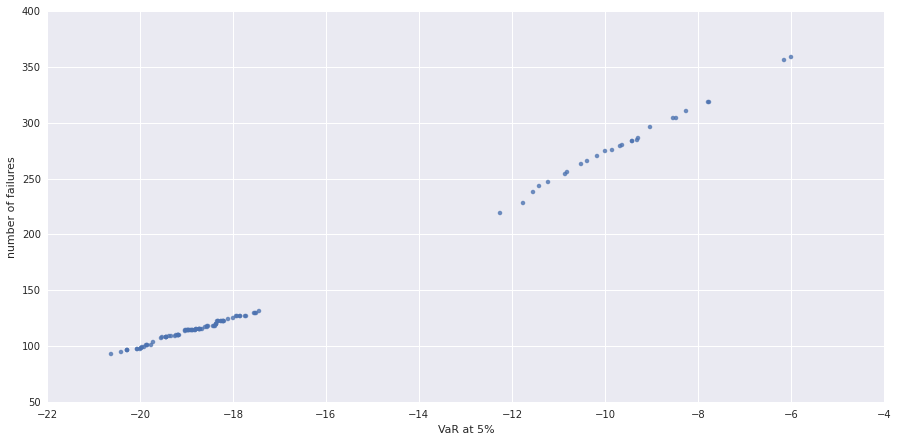

In [107]:
plt.figure(figsize = (15,7))
VaR_s = np.array([l[1] for l in all_lines_with_failures])
failures = np.array([l[2] for l in all_lines_with_failures])
sns.regplot(y=failures, x=VaR_s,fit_reg=False)
plt.xlabel('VaR at 5%')
plt.ylabel('number of failures')
plt.show()

<div class="alert alert-success">
Looking at the graph, we can see that the beahaviour that we have deduced by the first 4 items is confirmed: when the VaR is near to 0, the number of failures increases. This makes sense because when the VaR 5% is near to 0 we are predicting thta the possible loss is less.
</div>

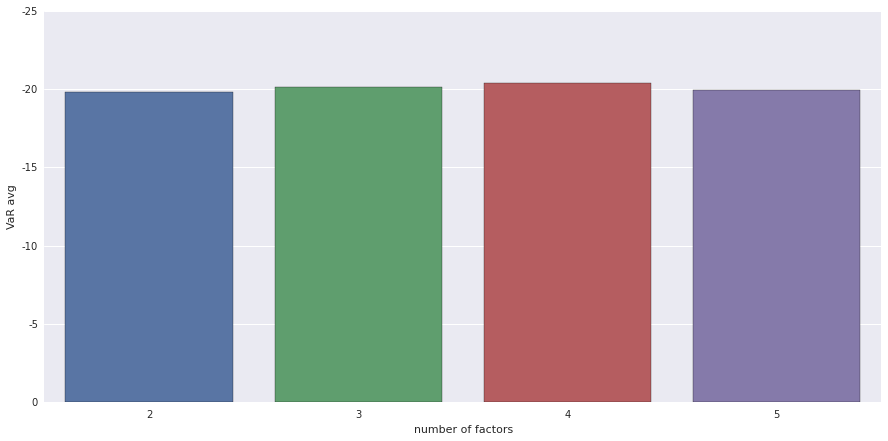

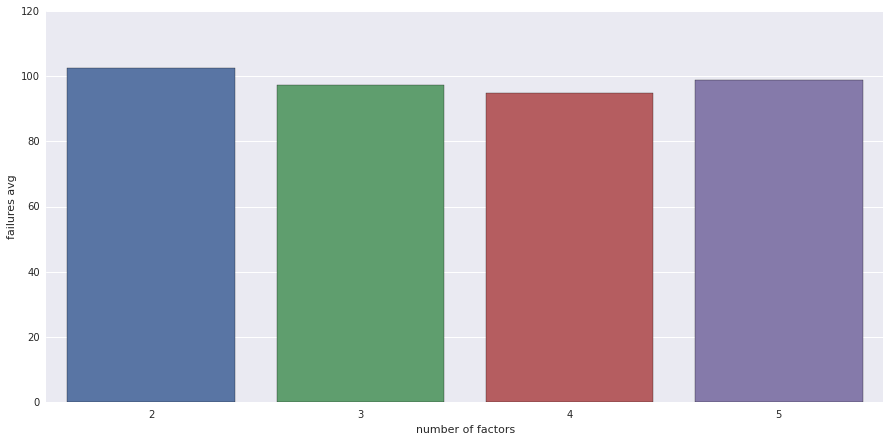

In [109]:
number_of_factors = {}
for l in all_lines_with_failures:
    key = len(l[0])
    if key in number_of_factors:
        number_of_factors[key][0] = (number_of_factors[key][0] + l[1])/2
        number_of_factors[key][1] = (number_of_factors[key][1] + float(l[2]))/2
    else:
        number_of_factors[key] = []
        number_of_factors[key].append(l[1])
        number_of_factors[key].append(float(l[2]))
                                   
number_of_factors = sorted(number_of_factors.items())
number_of_factors = [(n[0],n[1][0],n[1][1]) for n in number_of_factors]



factor_size = np.array([x[0] for x in number_of_factors])
vars_avg = np.abs(np.array([x[1] for x in number_of_factors]))
failures_avg = np.abs(np.array([x[2] for x in number_of_factors]))
                                    
plt.figure(figsize = (15,7))
ax = sns.barplot(y=vars_avg, x=factor_size)
ax.set(yticklabels=range(0,-30,-5) )
plt.xlabel('number of factors')
plt.ylabel('VaR avg')

plt.figure(figsize = (15,7))
ax = sns.barplot(y=failures_avg, x=factor_size)
plt.xlabel('number of factors')
plt.ylabel('failures avg')
plt.show()
        

<div class="alert alert-success">
Plotting these two graphs  we are trying to understand if there is a link between the number of considered factors and the VaR or between the number of considered factors and the failures avg. Actuallly we cannot note anything of noticable. These factors don't seem linked.
</div>

<div class="alert alert-success">
Now we want to see which the combinations of factors that produces the best kupiec value.
</div>

In [113]:
def kupiecTestPValue_(stocksReturns, valueAtRisk, confidenceLevel):
    failures = countFailures(stocksReturns, valueAtRisk)
    if failures == 0:
        # the model is very good
        return 1
    total = len(stocksReturns[0])
    testStatistic = kupiecTestStatistic(total, failures, confidenceLevel)
    #return 1 - stats.chi2.cdf(testStatistic, 1.0)
    return stats.chi2.sf(testStatistic, 1.0)

combination_var_failures_kupiec =[l+(kupiecTestPValue_(stocksReturns, l[1], 0.05),)   for l in all_lines_with_failures]

combination_var_failures_kupiec.sort(key=lambda x:x[3],reverse=True)

In [137]:
def getName(n):
    return new_factor_names[n]

print (combination_var_failures_kupiec[0])

best_kupiec_factors =[getName(n) for n in combination_var_failures_kupiec[0][0]]
print (best_kupiec_factors)


([1, 2, 3, 5], -20.6307249124, 93, 0.00069672615600983021)
['treasury bonds', 'GSPC', 'IXIC', 'GCM7']


<div class="alert alert-success">
As you can see, we get a best kupiec (0.00069672615600983021) respect to the initial case in which we used the basic factors. Also in this case the factors are 4 but the best one are different and they correspond to:
<br>
<ul>
  <li>treasury bonds</li>
  <li>Gold Futures (GCM7)</li>
  <li>GSPC</li>
  <li>IXIC</li>
</ul>
<br>
<br>
It's important to consider that we have run the simulation using only 35 stock files; we should test also how the factors impact changes with more file. However this requires to generate all combination and to test each one changing the number of stock files. We know that this should be the approach but we have not time to wait for the completation of the computation.
<br>
<br>

We can also say that, as we have explained before, we have chosen the new factors without having finacial experience. However we think that this approach is correct: try adding new factors, and selecting the ones that improves the kupiec, generating all possible combinations.
<br>
<br>

Below we'll try to see if, also using the gaussian mixture, the best considered market factors are the same. For the same problem of lack of time we'll n_components=4 fixed, that gave us the best results before.
</div>

In [148]:
def run_all_1_gmm(factorsReturns,weights):
    model = mixture.GMM(n_components=4, covariance_type='full',n_iter=1000,n_init=5)
    model.fit(np.column_stack(factorsReturns))
    parallelism = 12
    numTrials = 100000
    trial_indexes = list(range(0, parallelism))
    seedRDD = sc.parallelize(trial_indexes, parallelism)
    bFactorWeights = sc.broadcast(weights)

    trials = seedRDD.flatMap(lambda idx: \
                    simulateTrialReturns_gmm(
                        max(int(numTrials/parallelism), 1), 
                        bFactorWeights.value,
                        model
                    ))
    trials.cache()

    valueAtRisk = fivePercentVaR(trials)
    return valueAtRisk

In [150]:
def computeGMM(choice,f_wr):
    factors = list(map(lambda stock: \
                fillInHistory(
                    trimToRegion(stock, start, end), 
                start, end), 
                choice
                ))

    factorsReturns = list(map(twoWeekReturns, factors))
    factorMat = transpose(factorsReturns)

    # featurize each row of factorMat
    factorFeatures = list(map(featurize,factorMat))

    # OLS require parameter is a numpy array
    factor_columns = np.array(factorFeatures)

    #add a constant - the intercept term for each instrument i.
    factor_columns = sm.add_constant(factor_columns, prepend=True)

    weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns]
    return run_all_1_gmm(factorsReturns,weights)

In [151]:
with open('results_GMM.txt','w+') as f_wr:
    tot = '0123456'
    for length in range(2,6):
        permutations = list(choose_iter(tot, length))
        for p in permutations:
            choice = []
            for i in p:
                choice.append(allfactors[int(i)])
            res = str(computeGMM(choice,f_wr))
            f_wr.write("  ".join(p)+'|||'+res+'\n')

In [152]:
with open('results_GMM.txt') as f_rd:
    all_lines_GMM = f_rd.readlines()

all_lines_GMM = [l[0:-1].split('|||') for l in all_lines_GMM]
all_lines_GMM = [(list(map(int, l[0].split("  "))),float(l[1])) for l in all_lines_GMM]

all_lines_GMM.sort(key=lambda x:x[1],reverse=True)

all_lines_with_failures_GMM = [l+(countFailures(stocksReturns, l[1]),) for l in all_lines_GMM]
combination_var_failures_kupiec_GMM =[l+(kupiecTestPValue_(stocksReturns, l[1], 0.05),)   for l in all_lines_with_failures_GMM]

combination_var_failures_kupiec_GMM.sort(key=lambda x:x[3],reverse=True)


In [154]:
print (combination_var_failures_kupiec_GMM[0])

best_kupiec_factors_GMM =[getName(n) for n in combination_var_failures_kupiec_GMM[0][0]]
print (best_kupiec_factors_GMM)


([1, 2, 3, 4, 6], -23.1208740458, 75, 0.20186918639579876)
['treasury bonds', 'GSPC', 'IXIC', 'EUR_USD', 'SIN7']


<div class="alert alert-success">
Running  the Gaussian Mixture we obtain a kupiec value really better. It is not near 1 but we are using only 35 stock files. In addition in this case a higher number of factor  is selected (from 4 to 5). More precisely the selected factors are:
<br>
<ul>
  <li>treasury bonds</li>
  <li>GSPC</li>
  <li>IXIC</li>
  <li>EUR_USD</li>
  <li>SIN7</li>
</ul>
<br>
<br>
These are a little bit different from the ones selected before but the three factors are the same.
<br>
<br>
After all these trials, we can conclude that:
<br>
<ul>
  <li>the Gaussian MNixture works better than Multivariate Normal</li>
  <li>higher the number of stock files, higher the kupiec is</li>
</ul>

</div>